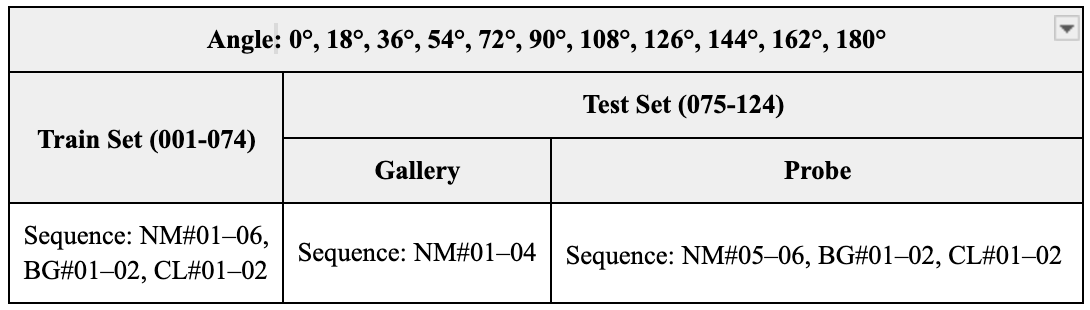

In [17]:
!pip install torchsampler

In [3]:
import os
from tqdm import tqdm
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from collections import defaultdict

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [4]:
dataset_path = '/Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b'

# Distribusi Data Original CASIA-B

In [6]:
import os
import pandas as pd
from collections import defaultdict

dataset_path = '/Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b'
train_subjects = [f"{i:03d}" for i in range(1, 75)]
test_subjects = [f"{i:03d}" for i in range(75, 125)]

def collect_data(subject_list):
    data = []
    for subject in sorted(subject_list):
        subject_path = os.path.join(dataset_path, subject)
        if not os.path.isdir(subject_path):
            continue
        for condition in os.listdir(subject_path):  # bg-01, nm-01, etc.
            condition_path = os.path.join(subject_path, condition)
            if not os.path.isdir(condition_path):
                continue
            for angle in os.listdir(condition_path):
                angle_path = os.path.join(condition_path, angle)
                if not os.path.isdir(angle_path):
                    continue
                for file in os.listdir(angle_path):
                    if file.endswith('.png'):
                        full_path = os.path.join(subject_path, condition, angle, file)
                        data.append((full_path, subject, condition))
    return data

# Kumpulkan data
train_data = collect_data(train_subjects)
test_data = collect_data(test_subjects)

# Konversi ke DataFrame
df_train = pd.DataFrame(train_data, columns=["path", "label", "condition"])
df_test = pd.DataFrame(test_data, columns=["path", "label", "condition"])

# Fungsi gabung kondisi: nm-01 → nm, bg-02 → bg, dll
def map_condition(cond):
    return cond.split('-')[0]

def show_grouped_distribution(df, name=""):
    df['main_condition'] = df['condition'].apply(map_condition)
    grouped = df['main_condition'].value_counts().sort_index()
    
    print(f"\nDistribusi data {name} (gabungan kondisi):")
    for k, v in grouped.items():
        print(f"{k}: {v}")
    print(f"Total: {len(df)}")

# Tampilkan distribusi
show_grouped_distribution(df_train, "Train")
show_grouped_distribution(df_test, "Test")
print(f"\nJumlah total data: {len(df_train) + len(df_test)}")


Distribusi data Train (gabungan kondisi):
bg: 132415
cl: 132487
nm: 406110
Total: 671012

Distribusi data Test (gabungan kondisi):
bg: 88843
cl: 88365
nm: 270153
Total: 447361

Jumlah total data: 1118373


# 1 Pra-Pemrosesan, Output GEI dan Split Dataset

In [3]:
MIN_FRAME_THRESHOLD = 30
output_root = 'split_gei'
os.makedirs(output_root, exist_ok=True)

train_csv = os.path.join(output_root, 'train.csv')
test_csv = os.path.join(output_root, 'test.csv')

with open(train_csv, 'w') as f:
    f.write('path,label,condition,angle\n')
with open(test_csv, 'w') as f:
    f.write('path,label,condition,angle\n')

In [4]:
def load_and_stack_images(image_dir, target_height=128, target_width=88):
    files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
    images = []
    for file in files:
        img_path = os.path.join(image_dir, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        # Crop ke bounding box
        coords = cv2.findNonZero(img)
        if coords is not None:
            x, y, w, h = cv2.boundingRect(coords)
            cropped = img[y:y+h, x:x+w]
        else:
            cropped = img

        # Resize sambil menjaga aspect ratio
        h_orig, w_orig = cropped.shape
        scale = target_height / h_orig
        new_w = int(w_orig * scale)
        resized = cv2.resize(cropped, (new_w, target_height), interpolation=cv2.INTER_AREA)

        # Padding atau crop tengah ke target_width
        if new_w < target_width:
            pad_left = (target_width - new_w) // 2
            pad_right = target_width - new_w - pad_left
            resized = cv2.copyMakeBorder(resized, 0, 0, pad_left, pad_right, cv2.BORDER_CONSTANT, value=0)
        elif new_w > target_width:
            offset = (new_w - target_width) // 2
            resized = resized[:, offset:offset+target_width]

        images.append(resized / 255.0)
    return np.array(images) if images else None

def compute_gei(images):
    return np.mean(images, axis=0)

def get_output_path(subject, condition, angle):
    subject_num = int(subject)
    condition_type = condition.split('-')[0].lower()
    seq_num = int(condition.split('-')[1])

    angle_int = int(angle)

    # TRAINING (001–074 seluruh sudut)
    if subject_num <= 74:
        split = 'training'

    # TESTING (075–124)
    elif subject_num >= 75:
        if condition_type == 'nm' and seq_num in [1, 2, 3, 4, 5, 6] and angle_int in range(0, 181, 18):
            split = 'testing'  # gallery
        elif condition_type in ['bg', 'cl'] and seq_num in [1, 2] and angle_int in range(0, 181, 18):
            split = 'testing'  # probe
        else:
            return None  # Data tidak sesuai split

    else:
        return None  # Data tidak sesuai split

    return os.path.join(output_root, split, subject, condition, angle), split, condition_type, str(angle_int)

In [5]:
start_time = time.time()
# simpan output
for subject in tqdm(sorted(os.listdir(dataset_path))):
    subject_path = os.path.join(dataset_path, subject)
    if not os.path.isdir(subject_path):
        continue

    for condition in sorted(os.listdir(subject_path)):
        condition_path = os.path.join(subject_path, condition)
        if not os.path.isdir(condition_path):
            continue

        for angle in sorted(os.listdir(condition_path)):
            angle_path = os.path.join(condition_path, angle)
            if not os.path.isdir(angle_path):
                continue

            images = load_and_stack_images(angle_path)
            if images is None or len(images) < MIN_FRAME_THRESHOLD:
                print(f"Skipping {angle_path} — only {len(images) if images is not None else 0} frames")
                continue

            gei = compute_gei(images)
            gei_uint8 = (gei * 255).astype(np.uint8)
            
            result = get_output_path(subject, condition, angle)
            if result is None:
                continue 

            save_path, split, cond, ang = result
            os.makedirs(save_path, exist_ok=True)

            filename = f"{condition}-{angle}.png"
            out_file = os.path.join(save_path, filename)
            cv2.imwrite(out_file, gei_uint8)
            
            # Tambahkan ke CSV
            rel_path = os.path.relpath(out_file, output_root)
            label_line = f"{rel_path},{subject},{condition},{angle}\n"
            with open(train_csv if split == 'training' else test_csv, 'a') as f:
                f.write(label_line)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\n⏱️ Waktu training selesai dalam {elapsed_time:.2f} detik "
      f"({elapsed_time/60:.2f} menit)")

  4%|█▋                                         | 5/125 [00:14<06:21,  3.18s/it]

Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/005/bg-01/000 — only 0 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/005/bg-01/072 — only 15 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/005/bg-01/090 — only 1 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/005/bg-01/108 — only 12 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/005/bg-02/000 — only 0 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/005/bg-02/072 — only 10 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/005/bg-02/090 — only 2 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/005/bg-02/108 — only 13 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/005/cl-01/000 — only 0 frames
Skipping /Users/nabilara

  5%|██                                         | 6/125 [00:16<05:38,  2.85s/it]

Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/005/nm-06/000 — only 0 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/005/nm-06/036 — only 26 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/005/nm-06/072 — only 25 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/005/nm-06/090 — only 3 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/005/nm-06/108 — only 20 frames


 21%|████████▋                                 | 26/125 [01:25<06:01,  3.65s/it]

Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/026/cl-02/162 — only 0 frames


 30%|████████████▍                             | 37/125 [02:06<05:29,  3.74s/it]

Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/037/bg-01/018 — only 9 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/037/bg-01/126 — only 6 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/037/bg-01/144 — only 0 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/037/bg-01/162 — only 0 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/037/bg-01/180 — only 0 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/037/bg-02/018 — only 5 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/037/bg-02/036 — only 2 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/037/bg-02/054 — only 0 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/037/bg-02/126 — only 0 frames
Skipping /Users/nabilarahmad

 38%|████████████████▏                         | 48/125 [02:43<04:23,  3.42s/it]

Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/048/bg-02/018 — only 4 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/048/cl-01/018 — only 4 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/048/cl-01/036 — only 3 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/048/cl-01/054 — only 23 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/048/cl-01/162 — only 0 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/048/cl-02/018 — only 4 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/048/cl-02/036 — only 2 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/048/cl-02/054 — only 0 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/048/cl-02/126 — only 0 frames
Skipping /Users/nabilarahma

 41%|█████████████████▏                        | 51/125 [02:53<03:58,  3.22s/it]

Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/051/nm-01/000 — only 11 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/051/nm-01/018 — only 16 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/051/nm-01/126 — only 29 frames


 54%|██████████████████████▊                   | 68/125 [03:48<03:11,  3.36s/it]

Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/068/nm-01/018 — only 7 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/068/nm-01/036 — only 9 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/068/nm-01/054 — only 0 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/068/nm-01/126 — only 0 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/068/nm-01/144 — only 0 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/068/nm-01/162 — only 0 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/068/nm-02/036 — only 6 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/068/nm-02/054 — only 4 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/068/nm-02/126 — only 0 frames
Skipping /Users/nabilarahmad

 63%|██████████████████████████▌               | 79/125 [04:25<02:36,  3.41s/it]

Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/079/bg-01/054 — only 8 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/079/bg-02/018 — only 9 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/079/bg-02/036 — only 9 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/079/bg-02/054 — only 0 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/079/bg-02/162 — only 0 frames


 70%|█████████████████████████████▌            | 88/125 [04:55<02:07,  3.45s/it]

Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/088/nm-02/018 — only 2 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/088/nm-02/036 — only 7 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/088/nm-02/054 — only 3 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/088/nm-03/018 — only 5 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/088/nm-03/036 — only 5 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/088/nm-03/054 — only 0 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/088/nm-03/126 — only 0 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/088/nm-03/162 — only 0 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/088/nm-03/180 — only 0 frames
Skipping /Users/nabilarahmad

 77%|████████████████████████████████▎         | 96/125 [05:23<01:40,  3.47s/it]

Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/096/nm-03/018 — only 4 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/096/nm-03/054 — only 3 frames


 87%|███████████████████████████████████▊     | 109/125 [06:05<00:56,  3.50s/it]

Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/109/nm-01/126 — only 0 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/109/nm-01/144 — only 0 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/109/nm-01/162 — only 0 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/109/nm-01/180 — only 0 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/109/nm-02/126 — only 12 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/109/nm-02/144 — only 13 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/109/nm-02/162 — only 12 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/109/nm-02/180 — only 11 frames
Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/109/nm-03/126 — only 17 frames
Skipping /Users/nabilar

 96%|███████████████████████████████████████▎ | 120/125 [06:44<00:18,  3.62s/it]

Skipping /Users/nabilarahmadhani/Documents/project-py/project-casia-b/casia-b/120/nm-06/054 — only 28 frames


100%|█████████████████████████████████████████| 125/125 [07:00<00:00,  3.36s/it]


⏱️ Waktu training selesai dalam 420.16 detik (7.00 menit)


# 2. Eksplorasi Representasi & Visualisasi GEI

In [4]:
CSV_TRAIN = 'split_gei/train.csv'
CSV_TEST = 'split_gei/test.csv'
DF_TRAIN = pd.read_csv(CSV_TRAIN)
DF_TEST = pd.read_csv(CSV_TEST)

TOTAL_TRAIN = len(DF_TRAIN)
print("Lima baris pertama dari train.csv:")
print(DF_TRAIN.head())
print(f"\nTotal jumlah data (baris) dalam file CSV '{CSV_TRAIN}': {TOTAL_TRAIN}")

TOTAL_TEST = len(DF_TEST)
print("\nLima baris pertama dari test.csv:")
print(DF_TEST.head())
print(f"\nTotal jumlah data (baris) dalam file CSV '{CSV_TEST}': {TOTAL_TEST}")

Lima baris pertama dari train.csv:
                                   path  label condition  angle
0  training/001/bg-01/000/bg-01-000.png      1     bg-01      0
1  training/001/bg-01/018/bg-01-018.png      1     bg-01     18
2  training/001/bg-01/036/bg-01-036.png      1     bg-01     36
3  training/001/bg-01/054/bg-01-054.png      1     bg-01     54
4  training/001/bg-01/072/bg-01-072.png      1     bg-01     72

Total jumlah data (baris) dalam file CSV 'split_gei/train.csv': 8057

Lima baris pertama dari test.csv:
                                  path  label condition  angle
0  testing/075/bg-01/000/bg-01-000.png     75     bg-01      0
1  testing/075/bg-01/018/bg-01-018.png     75     bg-01     18
2  testing/075/bg-01/036/bg-01-036.png     75     bg-01     36
3  testing/075/bg-01/054/bg-01-054.png     75     bg-01     54
4  testing/075/bg-01/072/bg-01-072.png     75     bg-01     72

Total jumlah data (baris) dalam file CSV 'split_gei/test.csv': 5460


In [5]:
# Hitung jumlah data per kondisi (condition) di masing-masing CSV
train_counts = DF_TRAIN['condition'].value_counts().sort_index()
test_counts = DF_TEST['condition'].value_counts().sort_index()

# Tampilkan hasil
print("=== TRAIN SET ===")
print(train_counts)

print("\n=== TEST SET ===")
print(test_counts)

# Jika ingin total gabungan juga:
print("\n=== TOTAL (TRAIN + TEST) ===")
total_counts = train_counts.add(test_counts, fill_value=0).astype(int)
print(total_counts)


=== TRAIN SET ===
condition
bg-01    805
bg-02    802
cl-01    807
cl-02    806
nm-01    802
nm-02    805
nm-03    803
nm-04    805
nm-05    813
nm-06    809
Name: count, dtype: int64

=== TEST SET ===
condition
bg-01    549
bg-02    546
cl-01    550
cl-02    550
nm-01    546
nm-02    543
nm-03    538
nm-04    539
nm-05    550
nm-06    549
Name: count, dtype: int64

=== TOTAL (TRAIN + TEST) ===
condition
bg-01    1354
bg-02    1348
cl-01    1357
cl-02    1356
nm-01    1348
nm-02    1348
nm-03    1341
nm-04    1344
nm-05    1363
nm-06    1358
Name: count, dtype: int64


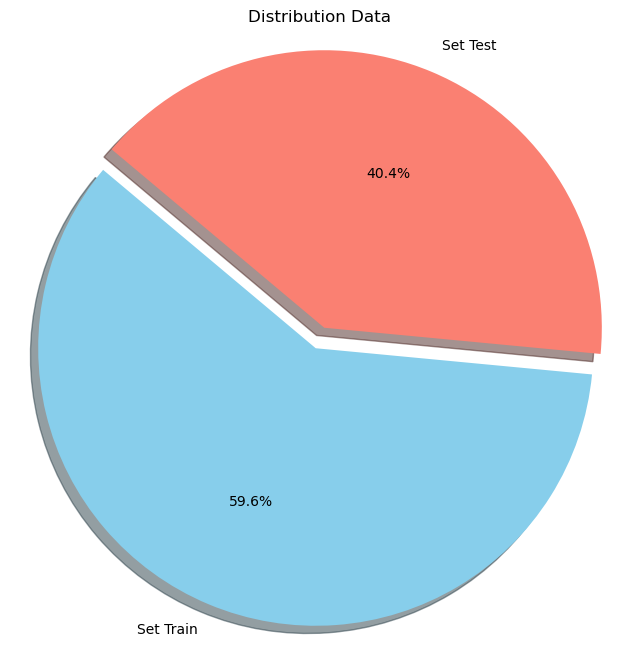

In [7]:
labels = ['Set Train', 'Set Test']
sizes = [TOTAL_TRAIN, TOTAL_TEST]
colors = ['skyblue', 'salmon']
explode = (0.08, 0)

# Membuat diagram pie
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution Data')
plt.axis('equal')
plt.show()

In [8]:
def plot_gei_grid(subject='075', base_dir='split_gei/testing', angles=['000','090','180'], conditions=['nm-01', 'bg-01', 'cl-01']):
    fig, axs = plt.subplots(len(conditions), len(angles), figsize=(12, 6))
    for i, cond in enumerate(conditions):
        for j, angle in enumerate(angles):
            img_path = os.path.join(base_dir, subject, cond, angle, f"{cond}-{angle}.png")
            if os.path.exists(img_path):
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                axs[i, j].imshow(img, cmap='gray')
                axs[i, j].set_title(f"{cond}, angle {angle}")
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()

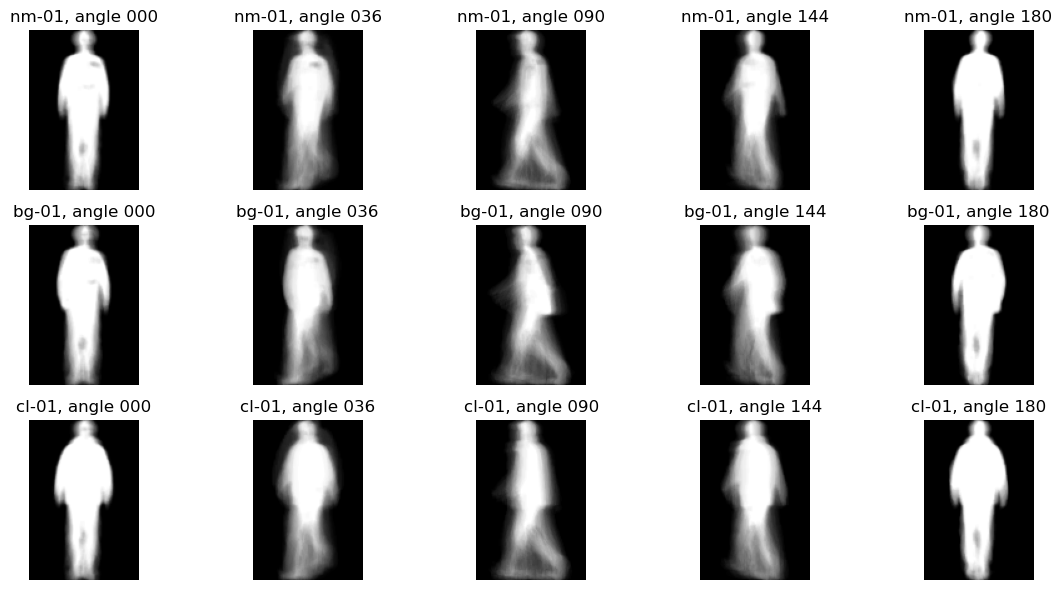

In [9]:
plot_gei_grid(
    subject='075',
    base_dir='split_gei/testing',
    angles=['000', '036', '090', '144', '180'],
    conditions=['nm-01', 'bg-01', 'cl-01']
)

# 3. Train Model

In [3]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.distance import cdist

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsampler import ImbalancedDatasetSampler
from pytorch_metric_learning.samplers import MPerClassSampler
import matplotlib.pyplot as plt

# === CONFIG ===
CSV_TRAIN = 'split_gei/train.csv'
CSV_TEST = 'split_gei/test.csv'
IMG_ROOT = 'split_gei'
IMG_SIZE = (128, 88)

BATCH_SIZE = 32
EMBED_DIM = 256
MARGIN = 0.4
DROPOUT = 0.3
LR = 1e-3
EPOCHS = 150
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 3.1 Model CNN Full GEI

In [4]:
# === TRANSFORM ===
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
#     transforms.RandomErasing(p=0.4, scale=(0.02, 0.2), value=0),
#     transforms.Lambda(lambda x: x + 0.01 * torch.randn_like(x)),
    transforms.Normalize((0.5,), (0.5,))
])

# === DATASET ===
class GEIDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(IMG_ROOT, row['path'])
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        label = row['label']
        return image, label

# === MODEL ===
class GEINet(nn.Module):
    def __init__(self, embedding_dim=256):
        super(GEINet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2),
            
            nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling
        )
        self.embedding = nn.Linear(256, embedding_dim)
        self.dropout = nn.Dropout(p=DROPOUT)
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.embedding(x)
        x = self.dropout(x)  # Apply dropout to embedding layer
        return x

# === BATCH-HARD TRIPLET LOSS ===
def batch_hard_triplet_loss(embeddings, labels, margin=0.2):
    pairwise_dist = torch.cdist(embeddings, embeddings, p=2)
    labels = labels.unsqueeze(1)
    mask_pos = (labels == labels.T).float() - torch.eye(labels.size(0), device=embeddings.device)
    mask_neg = (labels != labels.T).float()
    hardest_positive = (pairwise_dist * mask_pos).max(1)[0]
    max_dist = pairwise_dist.max().item()
    masked_neg = pairwise_dist + max_dist * (1.0 - mask_neg)
    hardest_negative = masked_neg.min(1)[0]
    loss = F.relu(hardest_positive - hardest_negative + margin)
    return loss.mean()

# === TRAINING ===
def train():
    df_train = pd.read_csv(CSV_TRAIN)
#     le = LabelEncoder()
#     df_train['label'] = le.fit_transform(df_train['label'])
    df_train['label'] = df_train['label'].astype(int)
    
    dataset = GEIDataset(df_train, transform=transform)
    sampler = MPerClassSampler(df_train['label'], m=4, length_before_new_iter=len(df_train))
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=sampler)

    model = GEINet(embedding_dim=EMBED_DIM).to(DEVICE)
    optimizer = Adam(model.parameters(), lr=LR)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    loss_history = []  # Simpan loss per epoch

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for images, labels in tqdm(dataloader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            embeddings = model(images)
            loss = batch_hard_triplet_loss(embeddings, labels, margin=MARGIN)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        scheduler.step(avg_loss)
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}")

    # Simpan model
    torch.save(model.state_dict(), "cnn_gei_triplet.pth")

    # Tampilkan grafik training loss
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, EPOCHS + 1), loss_history, marker='o')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.savefig('training_loss.png')
    plt.show()

In [5]:
# === EVALUATION ===
def extract_embeddings(model, df):
    model.eval()
    embeddings, labels = [], []
    with torch.no_grad():
        for _, row in tqdm(df.iterrows(), total=len(df)):
            img_path = os.path.join(IMG_ROOT, row['path'])
            img = Image.open(img_path).convert('L')
            img_tensor = transform(img).unsqueeze(0).to(DEVICE)
            embedding = model(img_tensor).cpu().numpy().flatten()
            embeddings.append(embedding)
            labels.append(row['label'])
    return np.array(embeddings), np.array(labels)

In [6]:
def evaluate_condition(save_embeddings=True):
    df_test = pd.read_csv(CSV_TEST)
#     le = LabelEncoder()
#     df_test['label'] = le.fit_transform(df_test['label'])
    df_test['label'] = df_test['label'].astype(int)

    gallery_df = df_test[df_test['condition'].isin(["nm-01", "nm-02", "nm-03", "nm-04"])]

    # Load trained model
    model = GEINet(embedding_dim=EMBED_DIM).to(DEVICE)
    model.load_state_dict(torch.load("cnn_gei_triplet.pth", map_location=DEVICE))

    # Extract gallery embeddings once
    gallery_embeddings, gallery_labels = extract_embeddings(model, gallery_df)

    if save_embeddings:
        np.save("gallery_embeddings.npy", gallery_embeddings)
        np.save("gallery_labels.npy", gallery_labels)

    # Define condition groups
    condition_groups = {
        'nm': ["nm-05", "nm-06"],
        'bg': ["bg-01", "bg-02"],
        'cl': ["cl-01", "cl-02"]
    }

    for group_name, conds in condition_groups.items():
        probe_df = df_test[df_test['condition'].isin(conds)]
        probe_embeddings, probe_labels = extract_embeddings(model, probe_df)

        dists = cdist(probe_embeddings, gallery_embeddings)
        ranks = np.argsort(dists, axis=1)

        correct_rank1 = 0
        correct_rank5 = 0

        for i in range(len(probe_labels)):
            sorted_labels = gallery_labels[ranks[i]]
            if probe_labels[i] == sorted_labels[0]:
                correct_rank1 += 1
            if probe_labels[i] in sorted_labels[:5]:
                correct_rank5 += 1

        rank1 = correct_rank1 / len(probe_labels)
        rank5 = correct_rank5 / len(probe_labels)
        print(f"Rank-1 Accuracy ({group_name}): {rank1:.4f}")
        print(f"Rank-5 Accuracy ({group_name}): {rank5:.4f}")

        if save_embeddings:
            np.save(f"probe_embeddings_{group_name}.npy", probe_embeddings)
            np.save(f"probe_labels_{group_name}.npy", probe_labels)

        # === Per-angle evaluation for each condition group ===
        print(f"\nRank-1 and Rank-5 Accuracy ({group_name}) per angle:")
        angles = sorted(probe_df['angle'].unique())
        for angle in angles:
            angle_df = probe_df[probe_df['angle'] == angle]
            if len(angle_df) == 0:
                continue
            angle_embeddings, angle_labels = extract_embeddings(model, angle_df)

            dists_angle = cdist(angle_embeddings, gallery_embeddings)
            ranks_angle = np.argsort(dists_angle, axis=1)

            correct_rank1_angle = 0
            correct_rank5_angle = 0
            for i in range(len(angle_labels)):
                sorted_labels = gallery_labels[ranks_angle[i]]
                if angle_labels[i] == sorted_labels[0]:
                    correct_rank1_angle += 1
                if angle_labels[i] in sorted_labels[:5]:
                    correct_rank5_angle += 1

            rank1_angle = correct_rank1_angle / len(angle_labels)
            rank5_angle = correct_rank5_angle / len(angle_labels)
            print(f"  Angle {angle}° - Rank-1: {rank1_angle:.4f}, Rank-5: {rank5_angle:.4f}")

100%|█████████████████████████████████████████| 250/250 [01:07<00:00,  3.71it/s]


Epoch 1/150, Loss: 0.6346


100%|█████████████████████████████████████████| 250/250 [01:15<00:00,  3.31it/s]


Epoch 2/150, Loss: 0.4991


100%|█████████████████████████████████████████| 250/250 [01:19<00:00,  3.15it/s]


Epoch 3/150, Loss: 0.4696


100%|█████████████████████████████████████████| 250/250 [01:18<00:00,  3.17it/s]


Epoch 4/150, Loss: 0.4462


100%|█████████████████████████████████████████| 250/250 [01:20<00:00,  3.09it/s]


Epoch 5/150, Loss: 0.4322


100%|█████████████████████████████████████████| 250/250 [01:28<00:00,  2.84it/s]


Epoch 6/150, Loss: 0.4234


100%|█████████████████████████████████████████| 250/250 [01:26<00:00,  2.90it/s]


Epoch 7/150, Loss: 0.4187


100%|█████████████████████████████████████████| 250/250 [01:23<00:00,  2.99it/s]


Epoch 8/150, Loss: 0.4147


100%|█████████████████████████████████████████| 250/250 [01:30<00:00,  2.76it/s]


Epoch 9/150, Loss: 0.4128


100%|█████████████████████████████████████████| 250/250 [01:34<00:00,  2.65it/s]


Epoch 10/150, Loss: 0.4121


100%|█████████████████████████████████████████| 250/250 [01:48<00:00,  2.31it/s]


Epoch 11/150, Loss: 0.4111


100%|█████████████████████████████████████████| 250/250 [01:50<00:00,  2.25it/s]


Epoch 12/150, Loss: 0.4104


100%|█████████████████████████████████████████| 250/250 [02:01<00:00,  2.05it/s]


Epoch 13/150, Loss: 0.4088


100%|█████████████████████████████████████████| 250/250 [02:07<00:00,  1.97it/s]


Epoch 14/150, Loss: 0.4082


100%|█████████████████████████████████████████| 250/250 [02:02<00:00,  2.04it/s]


Epoch 15/150, Loss: 0.4067


100%|█████████████████████████████████████████| 250/250 [02:00<00:00,  2.07it/s]


Epoch 16/150, Loss: 0.4063


100%|█████████████████████████████████████████| 250/250 [01:50<00:00,  2.26it/s]


Epoch 17/150, Loss: 0.4035


100%|█████████████████████████████████████████| 250/250 [02:07<00:00,  1.96it/s]


Epoch 18/150, Loss: 0.3988


100%|█████████████████████████████████████████| 250/250 [02:01<00:00,  2.06it/s]


Epoch 19/150, Loss: 0.3889


100%|█████████████████████████████████████████| 250/250 [02:11<00:00,  1.89it/s]


Epoch 20/150, Loss: 0.3600


100%|█████████████████████████████████████████| 250/250 [02:07<00:00,  1.95it/s]


Epoch 21/150, Loss: 0.3174


100%|█████████████████████████████████████████| 250/250 [02:16<00:00,  1.83it/s]


Epoch 22/150, Loss: 0.2674


100%|█████████████████████████████████████████| 250/250 [02:17<00:00,  1.82it/s]


Epoch 23/150, Loss: 0.2276


100%|█████████████████████████████████████████| 250/250 [02:14<00:00,  1.85it/s]


Epoch 24/150, Loss: 0.1995


100%|█████████████████████████████████████████| 250/250 [02:06<00:00,  1.98it/s]


Epoch 25/150, Loss: 0.1598


100%|█████████████████████████████████████████| 250/250 [02:02<00:00,  2.04it/s]


Epoch 26/150, Loss: 0.1491


100%|█████████████████████████████████████████| 250/250 [02:40<00:00,  1.56it/s]


Epoch 27/150, Loss: 0.1272


100%|█████████████████████████████████████████| 250/250 [02:16<00:00,  1.83it/s]


Epoch 28/150, Loss: 0.1197


100%|█████████████████████████████████████████| 250/250 [02:18<00:00,  1.81it/s]


Epoch 29/150, Loss: 0.1081


100%|█████████████████████████████████████████| 250/250 [02:01<00:00,  2.06it/s]


Epoch 30/150, Loss: 0.0937


100%|█████████████████████████████████████████| 250/250 [02:13<00:00,  1.87it/s]


Epoch 31/150, Loss: 0.0865


100%|█████████████████████████████████████████| 250/250 [02:07<00:00,  1.96it/s]


Epoch 32/150, Loss: 0.0738


100%|█████████████████████████████████████████| 250/250 [02:06<00:00,  1.97it/s]


Epoch 33/150, Loss: 0.0760


100%|█████████████████████████████████████████| 250/250 [01:59<00:00,  2.09it/s]


Epoch 34/150, Loss: 0.0718


100%|█████████████████████████████████████████| 250/250 [01:55<00:00,  2.17it/s]


Epoch 35/150, Loss: 0.0716


100%|█████████████████████████████████████████| 250/250 [01:49<00:00,  2.29it/s]


Epoch 36/150, Loss: 0.0601


100%|█████████████████████████████████████████| 250/250 [01:54<00:00,  2.19it/s]


Epoch 37/150, Loss: 0.0626


100%|█████████████████████████████████████████| 250/250 [01:50<00:00,  2.27it/s]


Epoch 38/150, Loss: 0.0498


100%|█████████████████████████████████████████| 250/250 [01:58<00:00,  2.11it/s]


Epoch 39/150, Loss: 0.0540


100%|█████████████████████████████████████████| 250/250 [02:07<00:00,  1.97it/s]


Epoch 40/150, Loss: 0.0496


100%|█████████████████████████████████████████| 250/250 [02:10<00:00,  1.92it/s]


Epoch 41/150, Loss: 0.0490


100%|█████████████████████████████████████████| 250/250 [02:04<00:00,  2.01it/s]


Epoch 42/150, Loss: 0.0445


100%|█████████████████████████████████████████| 250/250 [02:05<00:00,  1.99it/s]


Epoch 43/150, Loss: 0.0500


100%|█████████████████████████████████████████| 250/250 [01:59<00:00,  2.09it/s]


Epoch 44/150, Loss: 0.0455


100%|█████████████████████████████████████████| 250/250 [02:00<00:00,  2.07it/s]


Epoch 45/150, Loss: 0.0336


100%|█████████████████████████████████████████| 250/250 [02:00<00:00,  2.07it/s]


Epoch 46/150, Loss: 0.0351


100%|█████████████████████████████████████████| 250/250 [01:58<00:00,  2.11it/s]


Epoch 47/150, Loss: 0.0392


100%|█████████████████████████████████████████| 250/250 [02:04<00:00,  2.01it/s]


Epoch 48/150, Loss: 0.0419


100%|█████████████████████████████████████████| 250/250 [01:45<00:00,  2.37it/s]


Epoch 49/150, Loss: 0.0357


100%|█████████████████████████████████████████| 250/250 [01:44<00:00,  2.39it/s]


Epoch 50/150, Loss: 0.0192


100%|█████████████████████████████████████████| 250/250 [01:53<00:00,  2.20it/s]


Epoch 51/150, Loss: 0.0164


100%|█████████████████████████████████████████| 250/250 [01:53<00:00,  2.21it/s]


Epoch 52/150, Loss: 0.0138


100%|█████████████████████████████████████████| 250/250 [01:54<00:00,  2.18it/s]


Epoch 53/150, Loss: 0.0104


100%|█████████████████████████████████████████| 250/250 [01:55<00:00,  2.17it/s]


Epoch 54/150, Loss: 0.0127


100%|█████████████████████████████████████████| 250/250 [01:55<00:00,  2.16it/s]


Epoch 55/150, Loss: 0.0121


100%|█████████████████████████████████████████| 250/250 [01:57<00:00,  2.13it/s]


Epoch 56/150, Loss: 0.0099


100%|█████████████████████████████████████████| 250/250 [02:03<00:00,  2.03it/s]


Epoch 57/150, Loss: 0.0136


100%|█████████████████████████████████████████| 250/250 [02:06<00:00,  1.98it/s]


Epoch 58/150, Loss: 0.0110


100%|█████████████████████████████████████████| 250/250 [02:42<00:00,  1.54it/s]


Epoch 59/150, Loss: 0.0110


100%|█████████████████████████████████████████| 250/250 [02:43<00:00,  1.53it/s]


Epoch 60/150, Loss: 0.0146


100%|█████████████████████████████████████████| 250/250 [02:07<00:00,  1.96it/s]


Epoch 61/150, Loss: 0.0072


100%|█████████████████████████████████████████| 250/250 [02:00<00:00,  2.07it/s]


Epoch 62/150, Loss: 0.0051


100%|█████████████████████████████████████████| 250/250 [02:06<00:00,  1.98it/s]


Epoch 63/150, Loss: 0.0058


100%|█████████████████████████████████████████| 250/250 [02:11<00:00,  1.90it/s]


Epoch 64/150, Loss: 0.0057


100%|█████████████████████████████████████████| 250/250 [02:15<00:00,  1.85it/s]


Epoch 65/150, Loss: 0.0043


100%|█████████████████████████████████████████| 250/250 [02:23<00:00,  1.74it/s]


Epoch 66/150, Loss: 0.0037


100%|█████████████████████████████████████████| 250/250 [02:28<00:00,  1.69it/s]


Epoch 67/150, Loss: 0.0044


100%|█████████████████████████████████████████| 250/250 [02:27<00:00,  1.69it/s]


Epoch 68/150, Loss: 0.0048


100%|█████████████████████████████████████████| 250/250 [02:16<00:00,  1.83it/s]


Epoch 69/150, Loss: 0.0053


100%|█████████████████████████████████████████| 250/250 [02:31<00:00,  1.66it/s]


Epoch 70/150, Loss: 0.0046


100%|█████████████████████████████████████████| 250/250 [02:48<00:00,  1.49it/s]


Epoch 71/150, Loss: 0.0036


100%|█████████████████████████████████████████| 250/250 [02:45<00:00,  1.51it/s]


Epoch 72/150, Loss: 0.0032


100%|█████████████████████████████████████████| 250/250 [02:45<00:00,  1.51it/s]


Epoch 73/150, Loss: 0.0026


100%|█████████████████████████████████████████| 250/250 [02:34<00:00,  1.62it/s]


Epoch 74/150, Loss: 0.0028


100%|█████████████████████████████████████████| 250/250 [01:52<00:00,  2.22it/s]


Epoch 75/150, Loss: 0.0020


100%|█████████████████████████████████████████| 250/250 [01:46<00:00,  2.36it/s]


Epoch 76/150, Loss: 0.0026


100%|█████████████████████████████████████████| 250/250 [01:44<00:00,  2.38it/s]


Epoch 77/150, Loss: 0.0022


100%|█████████████████████████████████████████| 250/250 [01:44<00:00,  2.40it/s]


Epoch 78/150, Loss: 0.0032


100%|█████████████████████████████████████████| 250/250 [01:43<00:00,  2.41it/s]


Epoch 79/150, Loss: 0.0015


100%|█████████████████████████████████████████| 250/250 [01:43<00:00,  2.42it/s]


Epoch 80/150, Loss: 0.0020


100%|█████████████████████████████████████████| 250/250 [01:47<00:00,  2.33it/s]


Epoch 81/150, Loss: 0.0026


100%|█████████████████████████████████████████| 250/250 [01:52<00:00,  2.22it/s]


Epoch 82/150, Loss: 0.0023


100%|█████████████████████████████████████████| 250/250 [01:55<00:00,  2.17it/s]


Epoch 83/150, Loss: 0.0018


100%|█████████████████████████████████████████| 250/250 [02:00<00:00,  2.08it/s]


Epoch 84/150, Loss: 0.0014


100%|█████████████████████████████████████████| 250/250 [01:56<00:00,  2.14it/s]


Epoch 85/150, Loss: 0.0020


100%|█████████████████████████████████████████| 250/250 [01:38<00:00,  2.55it/s]


Epoch 86/150, Loss: 0.0016


100%|█████████████████████████████████████████| 250/250 [01:38<00:00,  2.54it/s]


Epoch 87/150, Loss: 0.0016


100%|█████████████████████████████████████████| 250/250 [01:31<00:00,  2.74it/s]


Epoch 88/150, Loss: 0.0011


100%|█████████████████████████████████████████| 250/250 [01:28<00:00,  2.84it/s]


Epoch 89/150, Loss: 0.0016


100%|█████████████████████████████████████████| 250/250 [01:27<00:00,  2.85it/s]


Epoch 90/150, Loss: 0.0008


100%|█████████████████████████████████████████| 250/250 [01:26<00:00,  2.89it/s]


Epoch 91/150, Loss: 0.0015


100%|█████████████████████████████████████████| 250/250 [01:25<00:00,  2.93it/s]


Epoch 92/150, Loss: 0.0010


100%|█████████████████████████████████████████| 250/250 [01:26<00:00,  2.90it/s]


Epoch 93/150, Loss: 0.0008


100%|█████████████████████████████████████████| 250/250 [01:25<00:00,  2.92it/s]


Epoch 94/150, Loss: 0.0007


100%|█████████████████████████████████████████| 250/250 [01:25<00:00,  2.94it/s]


Epoch 95/150, Loss: 0.0011


100%|█████████████████████████████████████████| 250/250 [01:25<00:00,  2.92it/s]


Epoch 96/150, Loss: 0.0011


100%|█████████████████████████████████████████| 250/250 [01:26<00:00,  2.89it/s]


Epoch 97/150, Loss: 0.0011


100%|█████████████████████████████████████████| 250/250 [01:28<00:00,  2.84it/s]


Epoch 98/150, Loss: 0.0013


100%|█████████████████████████████████████████| 250/250 [01:27<00:00,  2.85it/s]


Epoch 99/150, Loss: 0.0010


100%|█████████████████████████████████████████| 250/250 [01:28<00:00,  2.83it/s]


Epoch 100/150, Loss: 0.0005


100%|█████████████████████████████████████████| 250/250 [01:28<00:00,  2.84it/s]


Epoch 101/150, Loss: 0.0010


100%|█████████████████████████████████████████| 250/250 [01:28<00:00,  2.83it/s]


Epoch 102/150, Loss: 0.0008


100%|█████████████████████████████████████████| 250/250 [01:29<00:00,  2.80it/s]


Epoch 103/150, Loss: 0.0011


100%|█████████████████████████████████████████| 250/250 [01:29<00:00,  2.80it/s]


Epoch 104/150, Loss: 0.0006


100%|█████████████████████████████████████████| 250/250 [01:29<00:00,  2.78it/s]


Epoch 105/150, Loss: 0.0009


100%|█████████████████████████████████████████| 250/250 [01:30<00:00,  2.77it/s]


Epoch 106/150, Loss: 0.0011


100%|█████████████████████████████████████████| 250/250 [01:30<00:00,  2.77it/s]


Epoch 107/150, Loss: 0.0008


100%|█████████████████████████████████████████| 250/250 [01:30<00:00,  2.78it/s]


Epoch 108/150, Loss: 0.0005


100%|█████████████████████████████████████████| 250/250 [01:30<00:00,  2.77it/s]


Epoch 109/150, Loss: 0.0008


100%|█████████████████████████████████████████| 250/250 [01:30<00:00,  2.77it/s]


Epoch 110/150, Loss: 0.0008


100%|█████████████████████████████████████████| 250/250 [01:31<00:00,  2.74it/s]


Epoch 111/150, Loss: 0.0009


100%|█████████████████████████████████████████| 250/250 [01:31<00:00,  2.72it/s]


Epoch 112/150, Loss: 0.0007


100%|█████████████████████████████████████████| 250/250 [01:31<00:00,  2.73it/s]


Epoch 113/150, Loss: 0.0008


100%|█████████████████████████████████████████| 250/250 [01:31<00:00,  2.75it/s]


Epoch 114/150, Loss: 0.0007


100%|█████████████████████████████████████████| 250/250 [01:31<00:00,  2.73it/s]


Epoch 115/150, Loss: 0.0008


100%|█████████████████████████████████████████| 250/250 [01:31<00:00,  2.73it/s]


Epoch 116/150, Loss: 0.0009


100%|█████████████████████████████████████████| 250/250 [01:31<00:00,  2.74it/s]


Epoch 117/150, Loss: 0.0006


100%|█████████████████████████████████████████| 250/250 [01:31<00:00,  2.72it/s]


Epoch 118/150, Loss: 0.0005


100%|█████████████████████████████████████████| 250/250 [01:31<00:00,  2.73it/s]


Epoch 119/150, Loss: 0.0009


100%|█████████████████████████████████████████| 250/250 [01:36<00:00,  2.59it/s]


Epoch 120/150, Loss: 0.0006


100%|█████████████████████████████████████████| 250/250 [01:39<00:00,  2.52it/s]


Epoch 121/150, Loss: 0.0004


100%|█████████████████████████████████████████| 250/250 [01:41<00:00,  2.47it/s]


Epoch 122/150, Loss: 0.0006


100%|█████████████████████████████████████████| 250/250 [01:41<00:00,  2.46it/s]


Epoch 123/150, Loss: 0.0005


100%|█████████████████████████████████████████| 250/250 [01:41<00:00,  2.47it/s]


Epoch 124/150, Loss: 0.0009


100%|█████████████████████████████████████████| 250/250 [01:41<00:00,  2.47it/s]


Epoch 125/150, Loss: 0.0007


100%|█████████████████████████████████████████| 250/250 [01:41<00:00,  2.46it/s]


Epoch 126/150, Loss: 0.0010


100%|█████████████████████████████████████████| 250/250 [01:41<00:00,  2.45it/s]


Epoch 127/150, Loss: 0.0005


100%|█████████████████████████████████████████| 250/250 [01:40<00:00,  2.48it/s]


Epoch 128/150, Loss: 0.0006


100%|█████████████████████████████████████████| 250/250 [01:41<00:00,  2.47it/s]


Epoch 129/150, Loss: 0.0004


100%|█████████████████████████████████████████| 250/250 [01:41<00:00,  2.46it/s]


Epoch 130/150, Loss: 0.0005


100%|█████████████████████████████████████████| 250/250 [01:38<00:00,  2.54it/s]


Epoch 131/150, Loss: 0.0006


100%|█████████████████████████████████████████| 250/250 [01:38<00:00,  2.53it/s]


Epoch 132/150, Loss: 0.0006


100%|█████████████████████████████████████████| 250/250 [01:40<00:00,  2.48it/s]


Epoch 133/150, Loss: 0.0009


100%|█████████████████████████████████████████| 250/250 [01:40<00:00,  2.49it/s]


Epoch 134/150, Loss: 0.0009


100%|█████████████████████████████████████████| 250/250 [01:40<00:00,  2.48it/s]


Epoch 135/150, Loss: 0.0007


100%|█████████████████████████████████████████| 250/250 [01:40<00:00,  2.48it/s]


Epoch 136/150, Loss: 0.0010


100%|█████████████████████████████████████████| 250/250 [01:40<00:00,  2.48it/s]


Epoch 137/150, Loss: 0.0005


100%|█████████████████████████████████████████| 250/250 [01:40<00:00,  2.50it/s]


Epoch 138/150, Loss: 0.0007


100%|█████████████████████████████████████████| 250/250 [01:40<00:00,  2.48it/s]


Epoch 139/150, Loss: 0.0005


100%|█████████████████████████████████████████| 250/250 [01:40<00:00,  2.48it/s]


Epoch 140/150, Loss: 0.0008


100%|█████████████████████████████████████████| 250/250 [01:39<00:00,  2.51it/s]


Epoch 141/150, Loss: 0.0006


100%|█████████████████████████████████████████| 250/250 [01:40<00:00,  2.49it/s]


Epoch 142/150, Loss: 0.0005


100%|█████████████████████████████████████████| 250/250 [01:40<00:00,  2.49it/s]


Epoch 143/150, Loss: 0.0006


100%|█████████████████████████████████████████| 250/250 [01:40<00:00,  2.48it/s]


Epoch 144/150, Loss: 0.0009


100%|█████████████████████████████████████████| 250/250 [01:40<00:00,  2.50it/s]


Epoch 145/150, Loss: 0.0008


100%|█████████████████████████████████████████| 250/250 [01:42<00:00,  2.44it/s]


Epoch 146/150, Loss: 0.0005


100%|█████████████████████████████████████████| 250/250 [01:41<00:00,  2.47it/s]


Epoch 147/150, Loss: 0.0004


100%|█████████████████████████████████████████| 250/250 [01:40<00:00,  2.48it/s]


Epoch 148/150, Loss: 0.0009


100%|█████████████████████████████████████████| 250/250 [01:39<00:00,  2.52it/s]


Epoch 149/150, Loss: 0.0009


100%|█████████████████████████████████████████| 250/250 [01:37<00:00,  2.56it/s]


Epoch 150/150, Loss: 0.0006


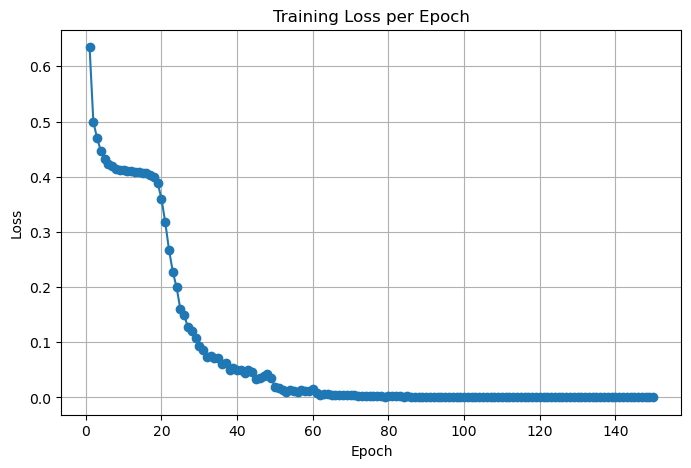


⏱️ Waktu training selesai dalam 16422.65 detik (273.71 menit)


In [7]:
if __name__ == '__main__':
    start_time = time.time()
    
    train()
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\n⏱️ Waktu training selesai dalam {elapsed_time:.2f} detik "
          f"({elapsed_time/60:.2f} menit)")

In [7]:
if __name__ == '__main__':
    start_time = time.time()
    
    evaluate_condition()
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\n⏱️ Waktu training selesai dalam {elapsed_time:.2f} detik "
          f"({elapsed_time/60:.2f} menit)")

100%|██████████████████████████████████████| 1099/1099 [00:02<00:00, 367.25it/s]


Rank-1 Accuracy (nm): 0.9745
Rank-5 Accuracy (nm): 0.9873

Rank-1 and Rank-5 Accuracy (nm) per angle:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 444.63it/s]


  Angle 0° - Rank-1: 0.9700, Rank-5: 0.9800


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 468.16it/s]


  Angle 18° - Rank-1: 1.0000, Rank-5: 1.0000


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 448.84it/s]


  Angle 36° - Rank-1: 0.9800, Rank-5: 0.9900


100%|██████████████████████████████████████████| 99/99 [00:00<00:00, 470.60it/s]


  Angle 54° - Rank-1: 0.9596, Rank-5: 0.9798


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 462.50it/s]


  Angle 72° - Rank-1: 0.9800, Rank-5: 0.9900


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 429.32it/s]


  Angle 90° - Rank-1: 0.9800, Rank-5: 0.9900


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 413.32it/s]


  Angle 108° - Rank-1: 0.9700, Rank-5: 0.9900


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 453.47it/s]


  Angle 126° - Rank-1: 0.9900, Rank-5: 1.0000


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 449.22it/s]


  Angle 144° - Rank-1: 0.9700, Rank-5: 0.9900


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 427.70it/s]


  Angle 162° - Rank-1: 0.9500, Rank-5: 0.9700


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 466.04it/s]


  Angle 180° - Rank-1: 0.9700, Rank-5: 0.9800


100%|██████████████████████████████████████| 1095/1095 [00:02<00:00, 372.56it/s]


Rank-1 Accuracy (bg): 0.8475
Rank-5 Accuracy (bg): 0.9306

Rank-1 and Rank-5 Accuracy (bg) per angle:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 440.72it/s]


  Angle 0° - Rank-1: 0.8400, Rank-5: 0.9300


100%|██████████████████████████████████████████| 99/99 [00:00<00:00, 445.28it/s]


  Angle 18° - Rank-1: 0.8283, Rank-5: 0.9394


100%|██████████████████████████████████████████| 99/99 [00:00<00:00, 445.79it/s]


  Angle 36° - Rank-1: 0.7980, Rank-5: 0.9192


100%|██████████████████████████████████████████| 98/98 [00:00<00:00, 456.17it/s]


  Angle 54° - Rank-1: 0.8367, Rank-5: 0.9490


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 448.43it/s]


  Angle 72° - Rank-1: 0.9100, Rank-5: 0.9700


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 415.11it/s]


  Angle 90° - Rank-1: 0.8200, Rank-5: 0.9300


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 443.15it/s]


  Angle 108° - Rank-1: 0.8300, Rank-5: 0.9100


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 451.16it/s]


  Angle 126° - Rank-1: 0.8700, Rank-5: 0.9500


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 457.57it/s]


  Angle 144° - Rank-1: 0.8700, Rank-5: 0.9300


100%|██████████████████████████████████████████| 99/99 [00:00<00:00, 463.46it/s]


  Angle 162° - Rank-1: 0.8485, Rank-5: 0.9293


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 455.59it/s]


  Angle 180° - Rank-1: 0.8700, Rank-5: 0.8800


100%|██████████████████████████████████████| 1100/1100 [00:03<00:00, 361.39it/s]


Rank-1 Accuracy (cl): 0.5727
Rank-5 Accuracy (cl): 0.7682

Rank-1 and Rank-5 Accuracy (cl) per angle:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 368.37it/s]


  Angle 0° - Rank-1: 0.5800, Rank-5: 0.6800


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 458.56it/s]


  Angle 18° - Rank-1: 0.6000, Rank-5: 0.7700


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 489.08it/s]


  Angle 36° - Rank-1: 0.6600, Rank-5: 0.8300


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 452.81it/s]


  Angle 54° - Rank-1: 0.6500, Rank-5: 0.8500


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 465.32it/s]


  Angle 72° - Rank-1: 0.6500, Rank-5: 0.8100


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 481.18it/s]


  Angle 90° - Rank-1: 0.5800, Rank-5: 0.8000


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 464.43it/s]


  Angle 108° - Rank-1: 0.5900, Rank-5: 0.7500


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 471.33it/s]


  Angle 126° - Rank-1: 0.6400, Rank-5: 0.8500


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 471.65it/s]


  Angle 144° - Rank-1: 0.5500, Rank-5: 0.7900


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 462.87it/s]


  Angle 162° - Rank-1: 0.4200, Rank-5: 0.6800


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 468.16it/s]

  Angle 180° - Rank-1: 0.3800, Rank-5: 0.6400

⏱️ Waktu training selesai dalam 24.42 detik (0.41 menit)


## 3.2 Model CNN Hard Mask GEI

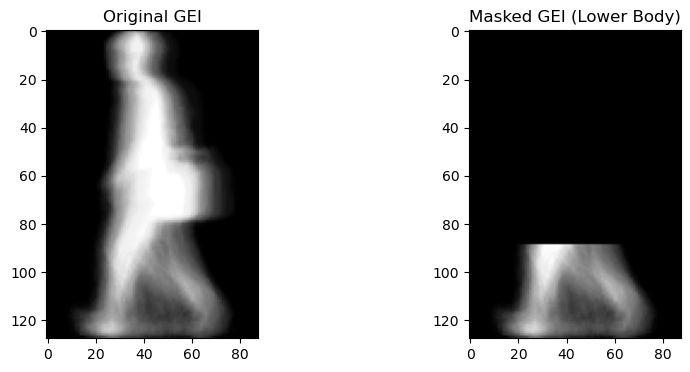

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def mask_gei(gei_image, region="lower"):
    """
    Mask a GEI image to extract specific body part region.
    
    region: "upper", "middle", "lower"
    """
    h, w = gei_image.shape
    mask = np.zeros_like(gei_image)

    if region == "upper":
        mask[:int(0.4 * h), :] = 1
    elif region == "middle":
        mask[int(0.4 * h):int(0.7 * h), :] = 1
    elif region == "lower":
        mask[int(0.7 * h):, :] = 1
    else:
        raise ValueError("Region must be 'upper', 'middle', or 'lower'.")

    return gei_image * mask

# Contoh penggunaan

gei = cv2.imread("/Users/nabilarahmadhani/Documents/project-py/project-casia-b/program/split_gei/training/001/bg-02/090/bg-02-090.png", cv2.IMREAD_GRAYSCALE)
masked_gei = mask_gei(gei, region="lower")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Original GEI")
plt.imshow(gei, cmap='gray')
plt.subplot(1,2,2)
plt.title("Masked GEI (Lower Body)")
plt.imshow(masked_gei, cmap='gray')
plt.show()


In [9]:
# === TRANSFORM ===
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def mask_lower_body(tensor, lower_ratio=0.7):
    """
    Mask bagian atas gambar, hanya menyisakan bagian bawah (kaki).
    Tensor input diasumsikan bentuk (1, H, W).
    """
    _, H, W = tensor.shape
    mask = torch.zeros((1, H, W))
    lower_start = int(H * lower_ratio)
    mask[:, lower_start:, :] = 1.0
    return tensor * mask

# === DATASET ===
class GEIDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(IMG_ROOT, row['path'])
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        image = mask_lower_body(image)  # <<< Tambahan: masking bagian atas
        label = row['label']
        return image, label

# === MODEL ===
class GEIHardMask(nn.Module):
    def __init__(self, embedding_dim=256):
        super(GEIHardMask, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2),
            
            nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling
        )
        self.embedding = nn.Linear(256, embedding_dim)
        self.dropout = nn.Dropout(p=DROPOUT)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.embedding(x)
        x = self.dropout(x)  # Apply dropout to embedding layer
        return x

# === BATCH-HARD TRIPLET LOSS ===
def batch_hard_triplet_loss(embeddings, labels, margin=0.2):
    pairwise_dist = torch.cdist(embeddings, embeddings, p=2)
    labels = labels.unsqueeze(1)
    mask_pos = (labels == labels.T).float() - torch.eye(labels.size(0), device=embeddings.device)
    mask_neg = (labels != labels.T).float()
    hardest_positive = (pairwise_dist * mask_pos).max(1)[0]
    max_dist = pairwise_dist.max().item()
    masked_neg = pairwise_dist + max_dist * (1.0 - mask_neg)
    hardest_negative = masked_neg.min(1)[0]
    loss = F.relu(hardest_positive - hardest_negative + margin)
    return loss.mean()

# === TRAINING ===
def train():
    df_train = pd.read_csv(CSV_TRAIN)
    le = LabelEncoder()
    df_train['label'] = le.fit_transform(df_train['label'])
    dataset = GEIDataset(df_train, transform=transform)
    sampler = MPerClassSampler(df_train['label'], m=4, length_before_new_iter=len(df_train))
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=sampler)

    model = GEIHardMask(embedding_dim=EMBED_DIM).to(DEVICE)
    optimizer = Adam(model.parameters(), lr=LR)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    loss_history = []  # Simpan loss per epoch

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for images, labels in tqdm(dataloader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            embeddings = model(images)
            loss = batch_hard_triplet_loss(embeddings, labels, margin=MARGIN)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        scheduler.step(avg_loss)
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}")

    # Simpan model
    torch.save(model.state_dict(), "GEIHardMask_triplet.pth")

    # Tampilkan grafik training loss
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, EPOCHS + 1), loss_history, marker='o')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.savefig('training_loss.png')
    plt.show()

In [10]:
def extract_embeddings(model, df):
    model.eval()
    embeddings, labels = [], []
    with torch.no_grad():
        for _, row in tqdm(df.iterrows(), total=len(df)):
            img_path = os.path.join(IMG_ROOT, row['path'])
            img = Image.open(img_path).convert('L')
            img_tensor = transform(img)
            img_tensor = mask_lower_body(img_tensor)  # Tambahkan masking
            img_tensor = img_tensor.unsqueeze(0).to(DEVICE)
            embedding = model(img_tensor).cpu().numpy().flatten()
            embeddings.append(embedding)
            labels.append(row['label'])
    return np.array(embeddings), np.array(labels)

def evaluate_condition(save_embeddings=True):
    df_test = pd.read_csv(CSV_TEST)
#     le = LabelEncoder()
#     df_test['label'] = le.fit_transform(df_test['label'])
    df_test['label'] = df_test['label'].astype(int)

    gallery_df = df_test[df_test['condition'].isin(["nm-01", "nm-02", "nm-03", "nm-04"])]

    # Load trained model
    model = GEINet(embedding_dim=EMBED_DIM).to(DEVICE)
    model.load_state_dict(torch.load("GEIHardMask_triplet.pth", map_location=DEVICE))

    # Extract gallery embeddings once
    gallery_embeddings, gallery_labels = extract_embeddings(model, gallery_df)

    if save_embeddings:
        np.save("gallery_embeddings.npy", gallery_embeddings)
        np.save("gallery_labels.npy", gallery_labels)

    # Define condition groups
    condition_groups = {
        'nm': ["nm-05", "nm-06"],
        'bg': ["bg-01", "bg-02"],
        'cl': ["cl-01", "cl-02"]
    }

    for group_name, conds in condition_groups.items():
        probe_df = df_test[df_test['condition'].isin(conds)]
        probe_embeddings, probe_labels = extract_embeddings(model, probe_df)

        dists = cdist(probe_embeddings, gallery_embeddings)
        ranks = np.argsort(dists, axis=1)

        correct_rank1 = 0
        correct_rank5 = 0

        for i in range(len(probe_labels)):
            sorted_labels = gallery_labels[ranks[i]]
            if probe_labels[i] == sorted_labels[0]:
                correct_rank1 += 1
            if probe_labels[i] in sorted_labels[:5]:
                correct_rank5 += 1

        rank1 = correct_rank1 / len(probe_labels)
        rank5 = correct_rank5 / len(probe_labels)
        print(f"Rank-1 Accuracy ({group_name}): {rank1:.4f}")
        print(f"Rank-5 Accuracy ({group_name}): {rank5:.4f}")

        if save_embeddings:
            np.save(f"probe_embeddings_{group_name}.npy", probe_embeddings)
            np.save(f"probe_labels_{group_name}.npy", probe_labels)

        # === Per-angle evaluation for each condition group ===
        print(f"\nRank-1 and Rank-5 Accuracy ({group_name}) per angle:")
        angles = sorted(probe_df['angle'].unique())
        for angle in angles:
            angle_df = probe_df[probe_df['angle'] == angle]
            if len(angle_df) == 0:
                continue
            angle_embeddings, angle_labels = extract_embeddings(model, angle_df)

            dists_angle = cdist(angle_embeddings, gallery_embeddings)
            ranks_angle = np.argsort(dists_angle, axis=1)

            correct_rank1_angle = 0
            correct_rank5_angle = 0
            for i in range(len(angle_labels)):
                sorted_labels = gallery_labels[ranks_angle[i]]
                if angle_labels[i] == sorted_labels[0]:
                    correct_rank1_angle += 1
                if angle_labels[i] in sorted_labels[:5]:
                    correct_rank5_angle += 1

            rank1_angle = correct_rank1_angle / len(angle_labels)
            rank5_angle = correct_rank5_angle / len(angle_labels)
            print(f"  Angle {angle}° - Rank-1: {rank1_angle:.4f}, Rank-5: {rank5_angle:.4f}")

100%|█████████████████████████████████████████| 250/250 [01:02<00:00,  3.97it/s]


Epoch 1/150, Loss: 0.5386


100%|█████████████████████████████████████████| 250/250 [01:09<00:00,  3.59it/s]


Epoch 2/150, Loss: 0.4285


100%|█████████████████████████████████████████| 250/250 [01:17<00:00,  3.22it/s]


Epoch 3/150, Loss: 0.4170


100%|█████████████████████████████████████████| 250/250 [01:22<00:00,  3.04it/s]


Epoch 4/150, Loss: 0.4129


100%|█████████████████████████████████████████| 250/250 [01:23<00:00,  2.98it/s]


Epoch 5/150, Loss: 0.4111


100%|█████████████████████████████████████████| 250/250 [01:20<00:00,  3.11it/s]


Epoch 6/150, Loss: 0.4093


100%|█████████████████████████████████████████| 250/250 [01:17<00:00,  3.24it/s]


Epoch 7/150, Loss: 0.4087


100%|█████████████████████████████████████████| 250/250 [01:18<00:00,  3.18it/s]


Epoch 8/150, Loss: 0.4077


100%|█████████████████████████████████████████| 250/250 [01:19<00:00,  3.15it/s]


Epoch 9/150, Loss: 0.4073


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.27it/s]


Epoch 10/150, Loss: 0.4068


100%|█████████████████████████████████████████| 250/250 [01:22<00:00,  3.03it/s]


Epoch 11/150, Loss: 0.4065


100%|█████████████████████████████████████████| 250/250 [01:21<00:00,  3.08it/s]


Epoch 12/150, Loss: 0.4063


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.25it/s]


Epoch 13/150, Loss: 0.4058


100%|█████████████████████████████████████████| 250/250 [01:23<00:00,  2.99it/s]


Epoch 14/150, Loss: 0.4056


100%|█████████████████████████████████████████| 250/250 [01:27<00:00,  2.84it/s]


Epoch 15/150, Loss: 0.4052


100%|█████████████████████████████████████████| 250/250 [01:34<00:00,  2.64it/s]


Epoch 16/150, Loss: 0.4050


100%|█████████████████████████████████████████| 250/250 [01:38<00:00,  2.55it/s]


Epoch 17/150, Loss: 0.4047


100%|█████████████████████████████████████████| 250/250 [01:36<00:00,  2.60it/s]


Epoch 18/150, Loss: 0.4046


100%|█████████████████████████████████████████| 250/250 [01:37<00:00,  2.57it/s]


Epoch 19/150, Loss: 0.4044


100%|█████████████████████████████████████████| 250/250 [01:37<00:00,  2.57it/s]


Epoch 20/150, Loss: 0.4043


100%|█████████████████████████████████████████| 250/250 [01:34<00:00,  2.63it/s]


Epoch 21/150, Loss: 0.4042


100%|█████████████████████████████████████████| 250/250 [01:42<00:00,  2.45it/s]


Epoch 22/150, Loss: 0.4039


100%|█████████████████████████████████████████| 250/250 [01:38<00:00,  2.54it/s]


Epoch 23/150, Loss: 0.4039


100%|█████████████████████████████████████████| 250/250 [01:32<00:00,  2.69it/s]


Epoch 24/150, Loss: 0.4038


100%|█████████████████████████████████████████| 250/250 [01:28<00:00,  2.82it/s]


Epoch 25/150, Loss: 0.4040


100%|█████████████████████████████████████████| 250/250 [01:30<00:00,  2.76it/s]


Epoch 26/150, Loss: 0.4038


100%|█████████████████████████████████████████| 250/250 [01:26<00:00,  2.89it/s]


Epoch 27/150, Loss: 0.4036


100%|█████████████████████████████████████████| 250/250 [01:30<00:00,  2.76it/s]


Epoch 28/150, Loss: 0.4037


100%|█████████████████████████████████████████| 250/250 [01:29<00:00,  2.80it/s]


Epoch 29/150, Loss: 0.4037


100%|█████████████████████████████████████████| 250/250 [01:27<00:00,  2.86it/s]


Epoch 30/150, Loss: 0.4035


100%|█████████████████████████████████████████| 250/250 [01:31<00:00,  2.74it/s]


Epoch 31/150, Loss: 0.4036


100%|█████████████████████████████████████████| 250/250 [01:47<00:00,  2.33it/s]


Epoch 32/150, Loss: 0.4036


100%|█████████████████████████████████████████| 250/250 [01:50<00:00,  2.26it/s]


Epoch 33/150, Loss: 0.4034


100%|█████████████████████████████████████████| 250/250 [01:55<00:00,  2.17it/s]


Epoch 34/150, Loss: 0.4038


100%|█████████████████████████████████████████| 250/250 [01:51<00:00,  2.24it/s]


Epoch 35/150, Loss: 0.4021


100%|█████████████████████████████████████████| 250/250 [01:45<00:00,  2.38it/s]


Epoch 36/150, Loss: 0.4017


100%|█████████████████████████████████████████| 250/250 [01:44<00:00,  2.40it/s]


Epoch 37/150, Loss: 0.4016


100%|█████████████████████████████████████████| 250/250 [01:41<00:00,  2.47it/s]


Epoch 38/150, Loss: 0.4015


100%|█████████████████████████████████████████| 250/250 [01:41<00:00,  2.46it/s]


Epoch 39/150, Loss: 0.4017


100%|█████████████████████████████████████████| 250/250 [01:48<00:00,  2.31it/s]


Epoch 40/150, Loss: 0.4016


100%|█████████████████████████████████████████| 250/250 [01:54<00:00,  2.18it/s]


Epoch 41/150, Loss: 0.4016


100%|█████████████████████████████████████████| 250/250 [01:46<00:00,  2.34it/s]


Epoch 42/150, Loss: 0.4015


100%|█████████████████████████████████████████| 250/250 [01:44<00:00,  2.38it/s]


Epoch 43/150, Loss: 0.4000


100%|█████████████████████████████████████████| 250/250 [01:37<00:00,  2.56it/s]


Epoch 44/150, Loss: 0.3994


100%|█████████████████████████████████████████| 250/250 [01:30<00:00,  2.76it/s]


Epoch 45/150, Loss: 0.3988


100%|█████████████████████████████████████████| 250/250 [01:22<00:00,  3.04it/s]


Epoch 46/150, Loss: 0.3979


100%|█████████████████████████████████████████| 250/250 [01:18<00:00,  3.18it/s]


Epoch 47/150, Loss: 0.3963


100%|█████████████████████████████████████████| 250/250 [01:20<00:00,  3.10it/s]


Epoch 48/150, Loss: 0.3951


100%|█████████████████████████████████████████| 250/250 [01:17<00:00,  3.22it/s]


Epoch 49/150, Loss: 0.3919


100%|█████████████████████████████████████████| 250/250 [01:18<00:00,  3.17it/s]


Epoch 50/150, Loss: 0.3855


100%|█████████████████████████████████████████| 250/250 [01:18<00:00,  3.19it/s]


Epoch 51/150, Loss: 0.3741


100%|█████████████████████████████████████████| 250/250 [01:18<00:00,  3.19it/s]


Epoch 52/150, Loss: 0.3555


100%|█████████████████████████████████████████| 250/250 [01:17<00:00,  3.23it/s]


Epoch 53/150, Loss: 0.3372


100%|█████████████████████████████████████████| 250/250 [01:18<00:00,  3.20it/s]


Epoch 54/150, Loss: 0.3146


100%|█████████████████████████████████████████| 250/250 [01:26<00:00,  2.88it/s]


Epoch 55/150, Loss: 0.2894


100%|█████████████████████████████████████████| 250/250 [01:19<00:00,  3.13it/s]


Epoch 56/150, Loss: 0.2844


100%|█████████████████████████████████████████| 250/250 [01:18<00:00,  3.18it/s]


Epoch 57/150, Loss: 0.2578


100%|█████████████████████████████████████████| 250/250 [01:20<00:00,  3.10it/s]


Epoch 58/150, Loss: 0.2473


100%|█████████████████████████████████████████| 250/250 [01:18<00:00,  3.20it/s]


Epoch 59/150, Loss: 0.2357


100%|█████████████████████████████████████████| 250/250 [01:19<00:00,  3.15it/s]


Epoch 60/150, Loss: 0.2252


100%|█████████████████████████████████████████| 250/250 [01:21<00:00,  3.09it/s]


Epoch 61/150, Loss: 0.2153


100%|█████████████████████████████████████████| 250/250 [01:22<00:00,  3.05it/s]


Epoch 62/150, Loss: 0.2102


100%|█████████████████████████████████████████| 250/250 [01:21<00:00,  3.06it/s]


Epoch 63/150, Loss: 0.2062


100%|█████████████████████████████████████████| 250/250 [01:18<00:00,  3.17it/s]


Epoch 64/150, Loss: 0.1868


100%|█████████████████████████████████████████| 250/250 [01:20<00:00,  3.09it/s]


Epoch 65/150, Loss: 0.1854


100%|█████████████████████████████████████████| 250/250 [01:20<00:00,  3.10it/s]


Epoch 66/150, Loss: 0.1781


100%|█████████████████████████████████████████| 250/250 [01:24<00:00,  2.97it/s]


Epoch 67/150, Loss: 0.1693


100%|█████████████████████████████████████████| 250/250 [01:22<00:00,  3.03it/s]


Epoch 68/150, Loss: 0.1546


100%|█████████████████████████████████████████| 250/250 [01:28<00:00,  2.83it/s]


Epoch 69/150, Loss: 0.1506


100%|█████████████████████████████████████████| 250/250 [01:30<00:00,  2.77it/s]


Epoch 70/150, Loss: 0.1466


100%|█████████████████████████████████████████| 250/250 [01:35<00:00,  2.61it/s]


Epoch 71/150, Loss: 0.1467


100%|█████████████████████████████████████████| 250/250 [01:44<00:00,  2.40it/s]


Epoch 72/150, Loss: 0.1433


100%|█████████████████████████████████████████| 250/250 [01:37<00:00,  2.56it/s]


Epoch 73/150, Loss: 0.1339


100%|█████████████████████████████████████████| 250/250 [01:28<00:00,  2.83it/s]


Epoch 74/150, Loss: 0.1384


100%|█████████████████████████████████████████| 250/250 [01:23<00:00,  3.01it/s]


Epoch 75/150, Loss: 0.1368


100%|█████████████████████████████████████████| 250/250 [01:20<00:00,  3.12it/s]


Epoch 76/150, Loss: 0.1233


100%|█████████████████████████████████████████| 250/250 [01:19<00:00,  3.15it/s]


Epoch 77/150, Loss: 0.1159


100%|█████████████████████████████████████████| 250/250 [01:20<00:00,  3.11it/s]


Epoch 78/150, Loss: 0.1212


100%|█████████████████████████████████████████| 250/250 [01:23<00:00,  3.00it/s]


Epoch 79/150, Loss: 0.1083


100%|█████████████████████████████████████████| 250/250 [01:22<00:00,  3.01it/s]


Epoch 80/150, Loss: 0.1057


100%|█████████████████████████████████████████| 250/250 [01:22<00:00,  3.02it/s]


Epoch 81/150, Loss: 0.1066


100%|█████████████████████████████████████████| 250/250 [01:20<00:00,  3.09it/s]


Epoch 82/150, Loss: 0.1028


100%|█████████████████████████████████████████| 250/250 [01:18<00:00,  3.19it/s]


Epoch 83/150, Loss: 0.1098


100%|█████████████████████████████████████████| 250/250 [01:18<00:00,  3.17it/s]


Epoch 84/150, Loss: 0.0979


100%|█████████████████████████████████████████| 250/250 [01:20<00:00,  3.12it/s]


Epoch 85/150, Loss: 0.0923


100%|█████████████████████████████████████████| 250/250 [01:20<00:00,  3.11it/s]


Epoch 86/150, Loss: 0.0956


100%|█████████████████████████████████████████| 250/250 [01:21<00:00,  3.09it/s]


Epoch 87/150, Loss: 0.0852


100%|█████████████████████████████████████████| 250/250 [01:20<00:00,  3.09it/s]


Epoch 88/150, Loss: 0.0905


100%|█████████████████████████████████████████| 250/250 [01:25<00:00,  2.93it/s]


Epoch 89/150, Loss: 0.0910


100%|█████████████████████████████████████████| 250/250 [01:30<00:00,  2.76it/s]


Epoch 90/150, Loss: 0.0821


100%|█████████████████████████████████████████| 250/250 [01:32<00:00,  2.69it/s]


Epoch 91/150, Loss: 0.0887


100%|█████████████████████████████████████████| 250/250 [01:34<00:00,  2.66it/s]


Epoch 92/150, Loss: 0.0850


100%|█████████████████████████████████████████| 250/250 [01:35<00:00,  2.61it/s]


Epoch 93/150, Loss: 0.0669


100%|█████████████████████████████████████████| 250/250 [01:37<00:00,  2.57it/s]


Epoch 94/150, Loss: 0.0779


100%|█████████████████████████████████████████| 250/250 [01:38<00:00,  2.54it/s]


Epoch 95/150, Loss: 0.0763


100%|█████████████████████████████████████████| 250/250 [01:37<00:00,  2.55it/s]


Epoch 96/150, Loss: 0.0745


100%|█████████████████████████████████████████| 250/250 [01:38<00:00,  2.55it/s]


Epoch 97/150, Loss: 0.0729


100%|█████████████████████████████████████████| 250/250 [01:37<00:00,  2.56it/s]


Epoch 98/150, Loss: 0.0545


100%|█████████████████████████████████████████| 250/250 [01:38<00:00,  2.53it/s]


Epoch 99/150, Loss: 0.0457


100%|█████████████████████████████████████████| 250/250 [01:36<00:00,  2.59it/s]


Epoch 100/150, Loss: 0.0412


100%|█████████████████████████████████████████| 250/250 [01:36<00:00,  2.59it/s]


Epoch 101/150, Loss: 0.0424


100%|█████████████████████████████████████████| 250/250 [01:36<00:00,  2.58it/s]


Epoch 102/150, Loss: 0.0375


100%|█████████████████████████████████████████| 250/250 [01:36<00:00,  2.58it/s]


Epoch 103/150, Loss: 0.0348


100%|█████████████████████████████████████████| 250/250 [01:35<00:00,  2.61it/s]


Epoch 104/150, Loss: 0.0360


100%|█████████████████████████████████████████| 250/250 [01:35<00:00,  2.62it/s]


Epoch 105/150, Loss: 0.0375


100%|█████████████████████████████████████████| 250/250 [01:34<00:00,  2.64it/s]


Epoch 106/150, Loss: 0.0326


100%|█████████████████████████████████████████| 250/250 [01:34<00:00,  2.65it/s]


Epoch 107/150, Loss: 0.0379


100%|█████████████████████████████████████████| 250/250 [01:35<00:00,  2.62it/s]


Epoch 108/150, Loss: 0.0348


100%|█████████████████████████████████████████| 250/250 [01:36<00:00,  2.60it/s]


Epoch 109/150, Loss: 0.0335


100%|█████████████████████████████████████████| 250/250 [01:37<00:00,  2.57it/s]


Epoch 110/150, Loss: 0.0328


100%|█████████████████████████████████████████| 250/250 [01:37<00:00,  2.58it/s]


Epoch 111/150, Loss: 0.0263


100%|█████████████████████████████████████████| 250/250 [01:36<00:00,  2.59it/s]


Epoch 112/150, Loss: 0.0250


100%|█████████████████████████████████████████| 250/250 [01:37<00:00,  2.55it/s]


Epoch 113/150, Loss: 0.0239


100%|█████████████████████████████████████████| 250/250 [01:36<00:00,  2.59it/s]


Epoch 114/150, Loss: 0.0197


100%|█████████████████████████████████████████| 250/250 [01:34<00:00,  2.63it/s]


Epoch 115/150, Loss: 0.0206


100%|█████████████████████████████████████████| 250/250 [01:35<00:00,  2.62it/s]


Epoch 116/150, Loss: 0.0181


100%|█████████████████████████████████████████| 250/250 [01:35<00:00,  2.63it/s]


Epoch 117/150, Loss: 0.0201


100%|█████████████████████████████████████████| 250/250 [01:36<00:00,  2.60it/s]


Epoch 118/150, Loss: 0.0192


100%|█████████████████████████████████████████| 250/250 [01:35<00:00,  2.61it/s]


Epoch 119/150, Loss: 0.0219


100%|█████████████████████████████████████████| 250/250 [01:35<00:00,  2.62it/s]


Epoch 120/150, Loss: 0.0161


100%|█████████████████████████████████████████| 250/250 [01:35<00:00,  2.62it/s]


Epoch 121/150, Loss: 0.0162


100%|█████████████████████████████████████████| 250/250 [01:35<00:00,  2.63it/s]


Epoch 122/150, Loss: 0.0173


100%|█████████████████████████████████████████| 250/250 [01:35<00:00,  2.61it/s]


Epoch 123/150, Loss: 0.0168


100%|█████████████████████████████████████████| 250/250 [01:35<00:00,  2.62it/s]


Epoch 124/150, Loss: 0.0162


100%|█████████████████████████████████████████| 250/250 [01:36<00:00,  2.58it/s]


Epoch 125/150, Loss: 0.0157


100%|█████████████████████████████████████████| 250/250 [01:37<00:00,  2.57it/s]


Epoch 126/150, Loss: 0.0142


100%|█████████████████████████████████████████| 250/250 [01:36<00:00,  2.59it/s]


Epoch 127/150, Loss: 0.0123


100%|█████████████████████████████████████████| 250/250 [01:37<00:00,  2.58it/s]


Epoch 128/150, Loss: 0.0120


100%|█████████████████████████████████████████| 250/250 [01:37<00:00,  2.55it/s]


Epoch 129/150, Loss: 0.0148


100%|█████████████████████████████████████████| 250/250 [01:38<00:00,  2.55it/s]


Epoch 130/150, Loss: 0.0119


100%|█████████████████████████████████████████| 250/250 [01:37<00:00,  2.56it/s]


Epoch 131/150, Loss: 0.0117


100%|█████████████████████████████████████████| 250/250 [01:38<00:00,  2.54it/s]


Epoch 132/150, Loss: 0.0149


100%|█████████████████████████████████████████| 250/250 [01:37<00:00,  2.55it/s]


Epoch 133/150, Loss: 0.0143


100%|█████████████████████████████████████████| 250/250 [01:39<00:00,  2.51it/s]


Epoch 134/150, Loss: 0.0128


100%|█████████████████████████████████████████| 250/250 [01:39<00:00,  2.50it/s]


Epoch 135/150, Loss: 0.0117


100%|█████████████████████████████████████████| 250/250 [01:39<00:00,  2.52it/s]


Epoch 136/150, Loss: 0.0116


100%|█████████████████████████████████████████| 250/250 [01:39<00:00,  2.51it/s]


Epoch 137/150, Loss: 0.0128


100%|█████████████████████████████████████████| 250/250 [01:39<00:00,  2.52it/s]


Epoch 138/150, Loss: 0.0123


100%|█████████████████████████████████████████| 250/250 [01:39<00:00,  2.52it/s]


Epoch 139/150, Loss: 0.0109


100%|█████████████████████████████████████████| 250/250 [01:39<00:00,  2.51it/s]


Epoch 140/150, Loss: 0.0115


100%|█████████████████████████████████████████| 250/250 [01:41<00:00,  2.46it/s]


Epoch 141/150, Loss: 0.0094


100%|█████████████████████████████████████████| 250/250 [01:41<00:00,  2.45it/s]


Epoch 142/150, Loss: 0.0125


100%|█████████████████████████████████████████| 250/250 [01:41<00:00,  2.46it/s]


Epoch 143/150, Loss: 0.0111


100%|█████████████████████████████████████████| 250/250 [01:41<00:00,  2.46it/s]


Epoch 144/150, Loss: 0.0132


100%|█████████████████████████████████████████| 250/250 [01:41<00:00,  2.47it/s]


Epoch 145/150, Loss: 0.0105


100%|█████████████████████████████████████████| 250/250 [01:41<00:00,  2.47it/s]


Epoch 146/150, Loss: 0.0101


100%|█████████████████████████████████████████| 250/250 [01:41<00:00,  2.45it/s]


Epoch 147/150, Loss: 0.0090


100%|█████████████████████████████████████████| 250/250 [01:41<00:00,  2.46it/s]


Epoch 148/150, Loss: 0.0094


100%|█████████████████████████████████████████| 250/250 [01:41<00:00,  2.47it/s]


Epoch 149/150, Loss: 0.0089


100%|█████████████████████████████████████████| 250/250 [01:40<00:00,  2.48it/s]

Epoch 150/150, Loss: 0.0083


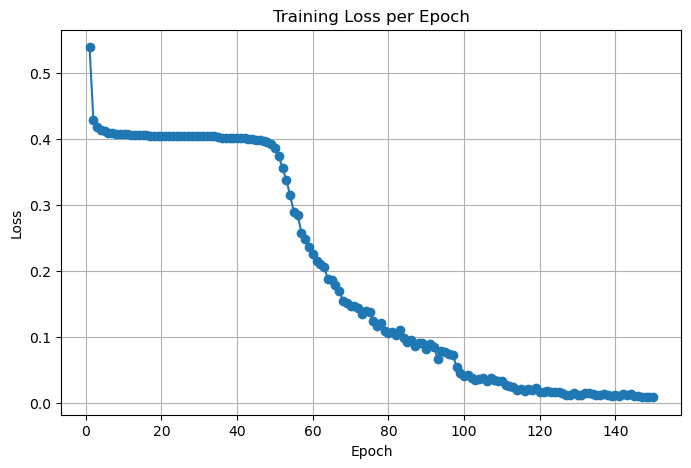


⏱️ Waktu training selesai dalam 13733.23 detik (228.89 menit)


In [11]:
if __name__ == '__main__':
    start_time = time.time()
    
    train()
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\n⏱️ Waktu training selesai dalam {elapsed_time:.2f} detik "
          f"({elapsed_time/60:.2f} menit)")

In [13]:
if __name__ == '__main__':
    start_time = time.time()
    
    evaluate_condition()
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\n⏱️ Waktu training selesai dalam {elapsed_time:.2f} detik "
          f"({elapsed_time/60:.2f} menit)")

100%|██████████████████████████████████████| 1099/1099 [00:04<00:00, 238.36it/s]


Rank-1 Accuracy (nm): 0.8335
Rank-5 Accuracy (nm): 0.9554

Rank-1 and Rank-5 Accuracy (nm) per angle:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 298.47it/s]


  Angle 0° - Rank-1: 0.8000, Rank-5: 0.9400


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 268.56it/s]


  Angle 18° - Rank-1: 0.8300, Rank-5: 0.9700


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 277.36it/s]


  Angle 36° - Rank-1: 0.8800, Rank-5: 0.9700


100%|██████████████████████████████████████████| 99/99 [00:00<00:00, 276.56it/s]


  Angle 54° - Rank-1: 0.8081, Rank-5: 0.9596


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 301.49it/s]


  Angle 72° - Rank-1: 0.8900, Rank-5: 0.9800


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 274.17it/s]


  Angle 90° - Rank-1: 0.9000, Rank-5: 0.9900


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 277.87it/s]


  Angle 108° - Rank-1: 0.8400, Rank-5: 0.9800


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 299.47it/s]


  Angle 126° - Rank-1: 0.8600, Rank-5: 0.9500


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 278.90it/s]


  Angle 144° - Rank-1: 0.7900, Rank-5: 0.9300


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 277.01it/s]


  Angle 162° - Rank-1: 0.8100, Rank-5: 0.9700


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 232.78it/s]


  Angle 180° - Rank-1: 0.7600, Rank-5: 0.8700


100%|██████████████████████████████████████| 1095/1095 [00:05<00:00, 214.85it/s]


Rank-1 Accuracy (bg): 0.5598
Rank-5 Accuracy (bg): 0.7726

Rank-1 and Rank-5 Accuracy (bg) per angle:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 316.69it/s]


  Angle 0° - Rank-1: 0.4600, Rank-5: 0.6800


100%|██████████████████████████████████████████| 99/99 [00:00<00:00, 285.96it/s]


  Angle 18° - Rank-1: 0.5758, Rank-5: 0.7879


100%|██████████████████████████████████████████| 99/99 [00:00<00:00, 300.34it/s]


  Angle 36° - Rank-1: 0.5354, Rank-5: 0.7374


100%|██████████████████████████████████████████| 98/98 [00:00<00:00, 275.22it/s]


  Angle 54° - Rank-1: 0.7041, Rank-5: 0.8367


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 289.46it/s]


  Angle 72° - Rank-1: 0.7500, Rank-5: 0.8800


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 307.58it/s]


  Angle 90° - Rank-1: 0.5700, Rank-5: 0.8500


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 288.63it/s]


  Angle 108° - Rank-1: 0.6000, Rank-5: 0.8000


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 274.21it/s]


  Angle 126° - Rank-1: 0.5100, Rank-5: 0.7600


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 167.94it/s]


  Angle 144° - Rank-1: 0.5800, Rank-5: 0.7600


100%|██████████████████████████████████████████| 99/99 [00:00<00:00, 263.77it/s]


  Angle 162° - Rank-1: 0.5051, Rank-5: 0.7273


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 264.88it/s]


  Angle 180° - Rank-1: 0.3700, Rank-5: 0.6800


100%|██████████████████████████████████████| 1100/1100 [00:04<00:00, 244.77it/s]


Rank-1 Accuracy (cl): 0.6355
Rank-5 Accuracy (cl): 0.8345

Rank-1 and Rank-5 Accuracy (cl) per angle:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 344.47it/s]


  Angle 0° - Rank-1: 0.5300, Rank-5: 0.7600


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 292.01it/s]


  Angle 18° - Rank-1: 0.6100, Rank-5: 0.8700


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 288.54it/s]


  Angle 36° - Rank-1: 0.6400, Rank-5: 0.8300


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 289.81it/s]


  Angle 54° - Rank-1: 0.7300, Rank-5: 0.9100


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 280.16it/s]


  Angle 72° - Rank-1: 0.7600, Rank-5: 0.9100


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 204.93it/s]


  Angle 90° - Rank-1: 0.7700, Rank-5: 0.9000


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 189.33it/s]


  Angle 108° - Rank-1: 0.6700, Rank-5: 0.8800


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 261.84it/s]


  Angle 126° - Rank-1: 0.7000, Rank-5: 0.8900


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 240.03it/s]


  Angle 144° - Rank-1: 0.6300, Rank-5: 0.8200


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 173.75it/s]


  Angle 162° - Rank-1: 0.4500, Rank-5: 0.7100


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 259.17it/s]


  Angle 180° - Rank-1: 0.5000, Rank-5: 0.7000

⏱️ Waktu training selesai dalam 37.92 detik (0.63 menit)


## 3.3 Model CNN Soft Mask GEI

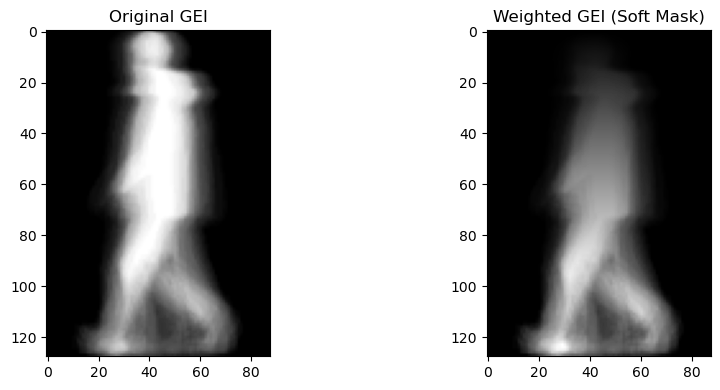

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def mask_lower_body_soft_visual(gei_image, emphasis="lower"):
    """
    Apply a soft weight mask to a GEI image emphasizing certain body region.
    """
    h, w = gei_image.shape
    grad = np.linspace(0, 1, h).reshape(h, 1)  # Gradien vertikal [0, 1]
    
    if emphasis == "upper":
        mask = 1 - grad
    elif emphasis == "middle":
        mask = 1 - 4 * np.abs(grad - 0.5)
        mask = np.clip(mask, 0, 1)
    elif emphasis == "lower":
        mask = grad
    else:
        raise ValueError("Emphasis must be 'upper', 'middle', or 'lower'.")

    mask = np.repeat(mask, w, axis=1)
    weighted_image = gei_image.astype(np.float32) * mask
    return weighted_image, mask


# Contoh penggunaan
gei = cv2.imread("/Users/nabilarahmadhani/Documents/project-py/project-casia-b/program/split_gei/training/001/cl-01/090/cl-01-090.png", cv2.IMREAD_GRAYSCALE)
weighted_gei, weight_mask = mask_lower_body_soft_visual(gei, emphasis="lower")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original GEI")
plt.imshow(gei, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Weighted GEI (Soft Mask)")
plt.imshow(weighted_gei, cmap='gray')

plt.tight_layout()
plt.show()

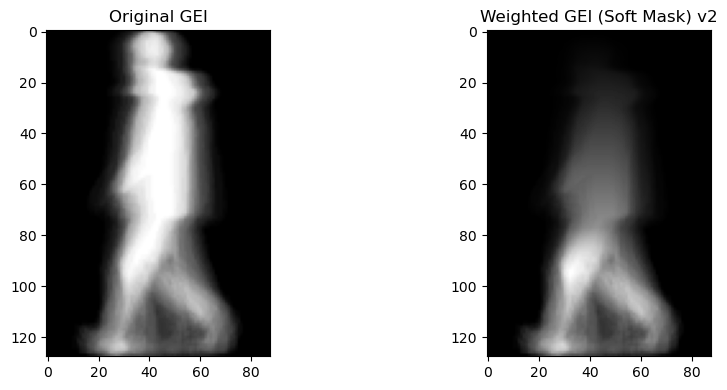

In [4]:
def mask_lower_body_soft_blend(gei_image, gamma=1.2, blend_start=0.55, blend_end=0.7):
    h, w = gei_image.shape
    grad = np.linspace(0, 1, h).reshape(h, 1) ** gamma
    mask = grad  # emphasis lower body

    # Buat soft blend mask
    soft_mask = np.where(
        mask >= blend_end, 
        1.0,  # tidak dimodifikasi
        np.where(
            mask <= blend_start,
            mask,  # gunakan masking biasa
            (mask - blend_start) / (blend_end - blend_start) * (1 - mask) + mask  # interpolasi halus
        )
    )

    soft_mask = np.repeat(soft_mask, w, axis=1)
    weighted_image = gei_image.astype(np.float32) * soft_mask

    return weighted_image, soft_mask


visual_gei_v2 = cv2.imread("/Users/nabilarahmadhani/Documents/project-py/project-casia-b/program/split_gei/training/001/cl-01/090/cl-01-090.png", cv2.IMREAD_GRAYSCALE)
weighted_gei, weight_mask = mask_lower_body_soft_blend(visual_gei_v2)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original GEI")
plt.imshow(visual_gei_v2, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Weighted GEI (Soft Mask) v2")
plt.imshow(weighted_gei, cmap='gray')

plt.tight_layout()
plt.show()

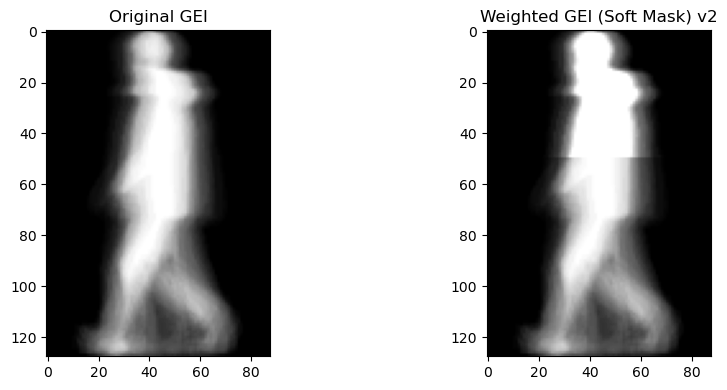

In [5]:
def emphasize_upper_body(gei_image, emphasis_factor=1.5, upper_threshold=50):
    """
    Mencerahkan bagian atas (kepala & badan) dari GEI tanpa mengubah bagian bawah.
    """
    gei = gei_image.astype(np.float32) / 255.0 if gei_image.max() > 1.0 else gei_image.copy()
    mask = np.ones_like(gei)
    mask[:upper_threshold, :] *= emphasis_factor

    gei_emphasized = np.clip(gei * mask, 0, 1)
    return gei_emphasized, mask

visual_gei_v3 = cv2.imread("/Users/nabilarahmadhani/Documents/project-py/project-casia-b/program/split_gei/training/001/cl-01/090/cl-01-090.png", cv2.IMREAD_GRAYSCALE)
weighted_gei, weight_mask = emphasize_upper_body(visual_gei_v3)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original GEI")
plt.imshow(visual_gei_v3, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Weighted GEI (Soft Mask) v2")
plt.imshow(weighted_gei, cmap='gray')

plt.tight_layout()
plt.show()

In [15]:
def mask_lower_body_soft_blend_tensor(tensor, gamma=1.2, blend_start=0.55, blend_end=0.7):
    """
    Terapkan soft blend mask ke tensor GEI. Tensor diasumsikan bentuknya (1, H, W).
    """
    _, H, W = tensor.shape
    y = torch.linspace(0, 1, steps=H).view(H, 1).pow(gamma)  # (H, 1)

    mask = y.clone()
    soft_mask = torch.where(
        mask >= blend_end,
        torch.ones_like(mask),
        torch.where(
            mask <= blend_start,
            mask,
            (mask - blend_start) / (blend_end - blend_start) * (1 - mask) + mask
        )
    )
    soft_mask = soft_mask.expand(H, W).unsqueeze(0)  # (1, H, W)
    return tensor * soft_mask

def mask_lower_body_soft(tensor, emphasis="lower", sigma=5):
    """
    Terapkan soft mask ke tensor GEI untuk penekanan bagian tubuh tertentu.
    Tensor diasumsikan berbentuk (1, H, W).
    """
    _, H, W = tensor.shape
    y = torch.linspace(0, 1, steps=H).view(H, 1)  # Gradien vertikal [0, 1]
    
    if emphasis == "upper":
        mask = 1 - y
    elif emphasis == "middle":
        mask = 1 - 4 * torch.abs(y - 0.5)
        mask = torch.clamp(mask, 0, 1)
    elif emphasis == "lower":
        mask = y
    else:
        raise ValueError("Emphasis must be 'upper', 'middle', or 'lower'.")

    mask = mask.expand(H, W).clone()
    mask = mask.unsqueeze(0)  # (1, H, W)
    return tensor * mask

def emphasize_upper_body_tensor(tensor, emphasis_factor=1.5, upper_threshold_ratio=0.4):
    """
    Mencerahkan bagian atas tensor GEI (1, H, W), untuk training.
    """
    _, H, W = tensor.shape
    upper_threshold = int(H * upper_threshold_ratio)

    # Buat mask (1, H, W)
    mask = torch.ones((H, W), dtype=tensor.dtype, device=tensor.device)
    mask[:upper_threshold, :] *= emphasis_factor
    mask = mask.unsqueeze(0)  # (1, H, W)

    return torch.clamp(tensor * mask, 0.0, 1.0)

In [17]:
# === TRANSFORM ===
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
])

# === DATASET ===
class GEIDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(IMG_ROOT, row['path'])
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        image = mask_lower_body_soft_blend_tensor(image)  # <<< Tambahan: masking bagian atas
        label = row['label']
        return image, label

# === MODEL ===
class GEINet(nn.Module):
    def __init__(self, embedding_dim=256):
        super(GEINet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2),
            
            nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling
        )
        self.embedding = nn.Linear(256, embedding_dim)
        self.dropout = nn.Dropout(p=DROPOUT)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.embedding(x)
        x = self.dropout(x)  # Apply dropout to embedding layer
        return x

# === BATCH-HARD TRIPLET LOSS ===
def batch_hard_triplet_loss(embeddings, labels, margin=0.2):
    pairwise_dist = torch.cdist(embeddings, embeddings, p=2)
    labels = labels.unsqueeze(1)
    mask_pos = (labels == labels.T).float() - torch.eye(labels.size(0), device=embeddings.device)
    mask_neg = (labels != labels.T).float()
    hardest_positive = (pairwise_dist * mask_pos).max(1)[0]
    max_dist = pairwise_dist.max().item()
    masked_neg = pairwise_dist + max_dist * (1.0 - mask_neg)
    hardest_negative = masked_neg.min(1)[0]
    loss = F.relu(hardest_positive - hardest_negative + margin)
    return loss.mean()

# === TRAINING ===
def train():
    df_train = pd.read_csv(CSV_TRAIN)
    le = LabelEncoder()
    df_train['label'] = le.fit_transform(df_train['label'])
    dataset = GEIDataset(df_train, transform=transform)
    sampler = MPerClassSampler(df_train['label'], m=4, length_before_new_iter=len(df_train))
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=sampler)

    model = GEINet(embedding_dim=EMBED_DIM).to(DEVICE)
    optimizer = Adam(model.parameters(), lr=LR)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    loss_history = []  # Simpan loss per epoch

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for images, labels in tqdm(dataloader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            embeddings = model(images)
            loss = batch_hard_triplet_loss(embeddings, labels, margin=MARGIN)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        scheduler.step(avg_loss)
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}")

    # Simpan model
    torch.save(model.state_dict(), "GEISoftMask_triplet.pth")

    # Tampilkan grafik training loss
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, EPOCHS + 1), loss_history, marker='o')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.savefig('training_loss.png')
    plt.show()

def extract_embeddings(model, df):
    model.eval()
    embeddings, labels = [], []
    with torch.no_grad():
        for _, row in tqdm(df.iterrows(), total=len(df)):
            img_path = os.path.join(IMG_ROOT, row['path'])
            img = Image.open(img_path).convert('L')
            img_tensor = transform(img)
            img_tensor = mask_lower_body_soft_blend_tensor(img_tensor)  # Tambahkan masking
            img_tensor = img_tensor.unsqueeze(0).to(DEVICE)
            embedding = model(img_tensor).cpu().numpy().flatten()
            embeddings.append(embedding)
            labels.append(row['label'])
    return np.array(embeddings), np.array(labels)

def evaluate_condition(save_embeddings=True):
    df_test = pd.read_csv(CSV_TEST)
    df_test['label'] = df_test['label'].astype(int)

    gallery_df = df_test[df_test['condition'].isin(["nm-01", "nm-02", "nm-03", "nm-04"])]

    # Load trained model
    model = GEINet(embedding_dim=EMBED_DIM).to(DEVICE)
    model.load_state_dict(torch.load("GEISoftMask_triplet.pth", map_location=DEVICE))

    # Extract gallery embeddings once
    gallery_embeddings, gallery_labels = extract_embeddings(model, gallery_df)

    if save_embeddings:
        np.save("gallery_embeddings.npy", gallery_embeddings)
        np.save("gallery_labels.npy", gallery_labels)

    # Define condition groups
    condition_groups = {
        'nm': ["nm-05", "nm-06"],
        'bg': ["bg-01", "bg-02"],
        'cl': ["cl-01", "cl-02"]
    }

    for group_name, conds in condition_groups.items():
        probe_df = df_test[df_test['condition'].isin(conds)]
        probe_embeddings, probe_labels = extract_embeddings(model, probe_df)

        dists = cdist(probe_embeddings, gallery_embeddings)
        ranks = np.argsort(dists, axis=1)

        correct_rank1 = 0
        correct_rank5 = 0

        for i in range(len(probe_labels)):
            sorted_labels = gallery_labels[ranks[i]]
            if probe_labels[i] == sorted_labels[0]:
                correct_rank1 += 1
            if probe_labels[i] in sorted_labels[:5]:
                correct_rank5 += 1

        rank1 = correct_rank1 / len(probe_labels)
        rank5 = correct_rank5 / len(probe_labels)
        print(f"Rank-1 Accuracy ({group_name}): {rank1:.4f}")
        print(f"Rank-5 Accuracy ({group_name}): {rank5:.4f}")

        if save_embeddings:
            np.save(f"probe_embeddings_{group_name}.npy", probe_embeddings)
            np.save(f"probe_labels_{group_name}.npy", probe_labels)

        # === Per-angle evaluation for each condition group ===
        print(f"\nRank-1 and Rank-5 Accuracy ({group_name}) per angle:")
        angles = sorted(probe_df['angle'].unique())
        for angle in angles:
            angle_df = probe_df[probe_df['angle'] == angle]
            if len(angle_df) == 0:
                continue
            angle_embeddings, angle_labels = extract_embeddings(model, angle_df)

            dists_angle = cdist(angle_embeddings, gallery_embeddings)
            ranks_angle = np.argsort(dists_angle, axis=1)

            correct_rank1_angle = 0
            correct_rank5_angle = 0
            for i in range(len(angle_labels)):
                sorted_labels = gallery_labels[ranks_angle[i]]
                if angle_labels[i] == sorted_labels[0]:
                    correct_rank1_angle += 1
                if angle_labels[i] in sorted_labels[:5]:
                    correct_rank5_angle += 1

            rank1_angle = correct_rank1_angle / len(angle_labels)
            rank5_angle = correct_rank5_angle / len(angle_labels)
            print(f"  Angle {angle}° - Rank-1: {rank1_angle:.4f}, Rank-5: {rank5_angle:.4f}")

100%|█████████████████████████████████████████| 250/250 [01:06<00:00,  3.79it/s]


Epoch 1/150, Loss: 0.6073


100%|█████████████████████████████████████████| 250/250 [01:14<00:00,  3.36it/s]


Epoch 2/150, Loss: 0.4857


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.28it/s]


Epoch 3/150, Loss: 0.4576


100%|█████████████████████████████████████████| 250/250 [01:15<00:00,  3.33it/s]


Epoch 4/150, Loss: 0.4452


100%|█████████████████████████████████████████| 250/250 [01:15<00:00,  3.30it/s]


Epoch 5/150, Loss: 0.4341


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.26it/s]


Epoch 6/150, Loss: 0.4278


100%|█████████████████████████████████████████| 250/250 [01:15<00:00,  3.31it/s]


Epoch 7/150, Loss: 0.4235


100%|█████████████████████████████████████████| 250/250 [01:15<00:00,  3.31it/s]


Epoch 8/150, Loss: 0.4204


100%|█████████████████████████████████████████| 250/250 [01:15<00:00,  3.31it/s]


Epoch 9/150, Loss: 0.4186


100%|█████████████████████████████████████████| 250/250 [01:15<00:00,  3.32it/s]


Epoch 10/150, Loss: 0.4167


100%|█████████████████████████████████████████| 250/250 [01:15<00:00,  3.30it/s]


Epoch 11/150, Loss: 0.4157


100%|█████████████████████████████████████████| 250/250 [01:15<00:00,  3.33it/s]


Epoch 12/150, Loss: 0.4146


100%|█████████████████████████████████████████| 250/250 [01:15<00:00,  3.32it/s]


Epoch 13/150, Loss: 0.4126


100%|█████████████████████████████████████████| 250/250 [01:15<00:00,  3.33it/s]


Epoch 14/150, Loss: 0.4093


100%|█████████████████████████████████████████| 250/250 [01:15<00:00,  3.33it/s]


Epoch 15/150, Loss: 0.4083


100%|█████████████████████████████████████████| 250/250 [01:15<00:00,  3.33it/s]


Epoch 16/150, Loss: 0.3988


100%|█████████████████████████████████████████| 250/250 [01:15<00:00,  3.30it/s]


Epoch 17/150, Loss: 0.3890


100%|█████████████████████████████████████████| 250/250 [01:15<00:00,  3.30it/s]


Epoch 18/150, Loss: 0.3600


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.28it/s]


Epoch 19/150, Loss: 0.3378


100%|█████████████████████████████████████████| 250/250 [01:15<00:00,  3.30it/s]


Epoch 20/150, Loss: 0.3003


100%|█████████████████████████████████████████| 250/250 [01:15<00:00,  3.30it/s]


Epoch 21/150, Loss: 0.2591


100%|█████████████████████████████████████████| 250/250 [01:15<00:00,  3.29it/s]


Epoch 22/150, Loss: 0.2297


100%|█████████████████████████████████████████| 250/250 [01:15<00:00,  3.30it/s]


Epoch 23/150, Loss: 0.2003


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.28it/s]


Epoch 24/150, Loss: 0.1902


100%|█████████████████████████████████████████| 250/250 [01:17<00:00,  3.24it/s]


Epoch 25/150, Loss: 0.1637


100%|█████████████████████████████████████████| 250/250 [01:17<00:00,  3.22it/s]


Epoch 26/150, Loss: 0.1486


100%|█████████████████████████████████████████| 250/250 [01:18<00:00,  3.20it/s]


Epoch 27/150, Loss: 0.1299


100%|█████████████████████████████████████████| 250/250 [01:17<00:00,  3.22it/s]


Epoch 28/150, Loss: 0.1175


100%|█████████████████████████████████████████| 250/250 [01:18<00:00,  3.20it/s]


Epoch 29/150, Loss: 0.1026


100%|█████████████████████████████████████████| 250/250 [01:18<00:00,  3.17it/s]


Epoch 30/150, Loss: 0.0993


100%|█████████████████████████████████████████| 250/250 [01:18<00:00,  3.18it/s]


Epoch 31/150, Loss: 0.0832


100%|█████████████████████████████████████████| 250/250 [01:18<00:00,  3.18it/s]


Epoch 32/150, Loss: 0.0808


100%|█████████████████████████████████████████| 250/250 [01:18<00:00,  3.19it/s]


Epoch 33/150, Loss: 0.0812


100%|█████████████████████████████████████████| 250/250 [01:18<00:00,  3.19it/s]


Epoch 34/150, Loss: 0.0782


100%|█████████████████████████████████████████| 250/250 [01:18<00:00,  3.18it/s]


Epoch 35/150, Loss: 0.0723


100%|█████████████████████████████████████████| 250/250 [01:18<00:00,  3.19it/s]


Epoch 36/150, Loss: 0.0796


100%|█████████████████████████████████████████| 250/250 [01:18<00:00,  3.19it/s]


Epoch 37/150, Loss: 0.0618


100%|█████████████████████████████████████████| 250/250 [01:18<00:00,  3.19it/s]


Epoch 38/150, Loss: 0.0615


100%|█████████████████████████████████████████| 250/250 [01:18<00:00,  3.17it/s]


Epoch 39/150, Loss: 0.0530


100%|█████████████████████████████████████████| 250/250 [01:18<00:00,  3.17it/s]


Epoch 40/150, Loss: 0.0612


100%|█████████████████████████████████████████| 250/250 [01:21<00:00,  3.06it/s]


Epoch 41/150, Loss: 0.0460


100%|█████████████████████████████████████████| 250/250 [01:23<00:00,  3.00it/s]


Epoch 42/150, Loss: 0.0471


100%|█████████████████████████████████████████| 250/250 [01:23<00:00,  3.00it/s]


Epoch 43/150, Loss: 0.0502


100%|█████████████████████████████████████████| 250/250 [01:23<00:00,  2.99it/s]


Epoch 44/150, Loss: 0.0518


100%|█████████████████████████████████████████| 250/250 [01:24<00:00,  2.97it/s]


Epoch 45/150, Loss: 0.0381


100%|█████████████████████████████████████████| 250/250 [01:23<00:00,  2.98it/s]


Epoch 46/150, Loss: 0.0434


100%|█████████████████████████████████████████| 250/250 [01:24<00:00,  2.96it/s]


Epoch 47/150, Loss: 0.0443


100%|█████████████████████████████████████████| 250/250 [01:24<00:00,  2.96it/s]


Epoch 48/150, Loss: 0.0470


100%|█████████████████████████████████████████| 250/250 [01:23<00:00,  2.98it/s]


Epoch 49/150, Loss: 0.0405


100%|█████████████████████████████████████████| 250/250 [01:23<00:00,  2.98it/s]


Epoch 50/150, Loss: 0.0208


100%|█████████████████████████████████████████| 250/250 [01:24<00:00,  2.96it/s]


Epoch 51/150, Loss: 0.0148


100%|█████████████████████████████████████████| 250/250 [01:24<00:00,  2.97it/s]


Epoch 52/150, Loss: 0.0145


100%|█████████████████████████████████████████| 250/250 [01:24<00:00,  2.96it/s]


Epoch 53/150, Loss: 0.0133


100%|█████████████████████████████████████████| 250/250 [01:24<00:00,  2.96it/s]


Epoch 54/150, Loss: 0.0128


100%|█████████████████████████████████████████| 250/250 [01:24<00:00,  2.95it/s]


Epoch 55/150, Loss: 0.0125


100%|█████████████████████████████████████████| 250/250 [01:24<00:00,  2.97it/s]


Epoch 56/150, Loss: 0.0155


100%|█████████████████████████████████████████| 250/250 [01:24<00:00,  2.97it/s]


Epoch 57/150, Loss: 0.0140


100%|█████████████████████████████████████████| 250/250 [01:24<00:00,  2.96it/s]


Epoch 58/150, Loss: 0.0138


100%|█████████████████████████████████████████| 250/250 [01:25<00:00,  2.94it/s]


Epoch 59/150, Loss: 0.0138


100%|█████████████████████████████████████████| 250/250 [01:24<00:00,  2.96it/s]


Epoch 60/150, Loss: 0.0091


100%|█████████████████████████████████████████| 250/250 [01:25<00:00,  2.94it/s]


Epoch 61/150, Loss: 0.0071


100%|█████████████████████████████████████████| 250/250 [01:24<00:00,  2.96it/s]


Epoch 62/150, Loss: 0.0056


100%|█████████████████████████████████████████| 250/250 [01:24<00:00,  2.96it/s]


Epoch 63/150, Loss: 0.0059


100%|█████████████████████████████████████████| 250/250 [01:24<00:00,  2.97it/s]


Epoch 64/150, Loss: 0.0053


100%|█████████████████████████████████████████| 250/250 [01:24<00:00,  2.95it/s]


Epoch 65/150, Loss: 0.0056


100%|█████████████████████████████████████████| 250/250 [01:24<00:00,  2.97it/s]


Epoch 66/150, Loss: 0.0064


100%|█████████████████████████████████████████| 250/250 [01:24<00:00,  2.97it/s]


Epoch 67/150, Loss: 0.0053


100%|█████████████████████████████████████████| 250/250 [01:23<00:00,  2.98it/s]


Epoch 68/150, Loss: 0.0041


100%|█████████████████████████████████████████| 250/250 [01:24<00:00,  2.95it/s]


Epoch 69/150, Loss: 0.0055


100%|█████████████████████████████████████████| 250/250 [01:24<00:00,  2.95it/s]


Epoch 70/150, Loss: 0.0048


100%|█████████████████████████████████████████| 250/250 [01:24<00:00,  2.95it/s]


Epoch 71/150, Loss: 0.0053


100%|█████████████████████████████████████████| 250/250 [01:25<00:00,  2.93it/s]


Epoch 72/150, Loss: 0.0061


100%|█████████████████████████████████████████| 250/250 [01:24<00:00,  2.94it/s]


Epoch 73/150, Loss: 0.0042


100%|█████████████████████████████████████████| 250/250 [01:24<00:00,  2.96it/s]


Epoch 74/150, Loss: 0.0031


100%|█████████████████████████████████████████| 250/250 [01:24<00:00,  2.95it/s]


Epoch 75/150, Loss: 0.0029


100%|█████████████████████████████████████████| 250/250 [01:26<00:00,  2.91it/s]


Epoch 76/150, Loss: 0.0034


100%|█████████████████████████████████████████| 250/250 [01:27<00:00,  2.86it/s]


Epoch 77/150, Loss: 0.0027


100%|█████████████████████████████████████████| 250/250 [01:26<00:00,  2.88it/s]


Epoch 78/150, Loss: 0.0034


100%|█████████████████████████████████████████| 250/250 [01:25<00:00,  2.93it/s]


Epoch 79/150, Loss: 0.0024


100%|█████████████████████████████████████████| 250/250 [01:24<00:00,  2.95it/s]


Epoch 80/150, Loss: 0.0021


100%|█████████████████████████████████████████| 250/250 [01:24<00:00,  2.95it/s]


Epoch 81/150, Loss: 0.0027


100%|█████████████████████████████████████████| 250/250 [01:24<00:00,  2.96it/s]


Epoch 82/150, Loss: 0.0019


100%|█████████████████████████████████████████| 250/250 [01:24<00:00,  2.95it/s]


Epoch 83/150, Loss: 0.0017


100%|█████████████████████████████████████████| 250/250 [01:24<00:00,  2.96it/s]


Epoch 84/150, Loss: 0.0023


100%|█████████████████████████████████████████| 250/250 [01:25<00:00,  2.92it/s]


Epoch 85/150, Loss: 0.0028


100%|█████████████████████████████████████████| 250/250 [01:25<00:00,  2.94it/s]


Epoch 86/150, Loss: 0.0024


100%|█████████████████████████████████████████| 250/250 [01:25<00:00,  2.93it/s]


Epoch 87/150, Loss: 0.0019


100%|█████████████████████████████████████████| 250/250 [01:23<00:00,  2.98it/s]


Epoch 88/150, Loss: 0.0019


100%|█████████████████████████████████████████| 250/250 [01:20<00:00,  3.10it/s]


Epoch 89/150, Loss: 0.0021


100%|█████████████████████████████████████████| 250/250 [01:19<00:00,  3.14it/s]


Epoch 90/150, Loss: 0.0016


100%|█████████████████████████████████████████| 250/250 [01:17<00:00,  3.22it/s]


Epoch 91/150, Loss: 0.0015


100%|█████████████████████████████████████████| 250/250 [01:17<00:00,  3.24it/s]


Epoch 92/150, Loss: 0.0019


100%|█████████████████████████████████████████| 250/250 [01:17<00:00,  3.24it/s]


Epoch 93/150, Loss: 0.0008


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.25it/s]


Epoch 94/150, Loss: 0.0012


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.25it/s]


Epoch 95/150, Loss: 0.0015


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.28it/s]


Epoch 96/150, Loss: 0.0016


100%|█████████████████████████████████████████| 250/250 [01:15<00:00,  3.29it/s]


Epoch 97/150, Loss: 0.0011


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.29it/s]


Epoch 98/150, Loss: 0.0013


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.28it/s]


Epoch 99/150, Loss: 0.0015


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.29it/s]


Epoch 100/150, Loss: 0.0012


100%|█████████████████████████████████████████| 250/250 [01:15<00:00,  3.29it/s]


Epoch 101/150, Loss: 0.0013


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.27it/s]


Epoch 102/150, Loss: 0.0008


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.28it/s]


Epoch 103/150, Loss: 0.0016


100%|█████████████████████████████████████████| 250/250 [01:15<00:00,  3.29it/s]


Epoch 104/150, Loss: 0.0009


100%|█████████████████████████████████████████| 250/250 [01:15<00:00,  3.30it/s]


Epoch 105/150, Loss: 0.0013


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.26it/s]


Epoch 106/150, Loss: 0.0011


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.27it/s]


Epoch 107/150, Loss: 0.0011


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.27it/s]


Epoch 108/150, Loss: 0.0009


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.27it/s]


Epoch 109/150, Loss: 0.0012


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.25it/s]


Epoch 110/150, Loss: 0.0008


100%|█████████████████████████████████████████| 250/250 [01:17<00:00,  3.25it/s]


Epoch 111/150, Loss: 0.0007


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.26it/s]


Epoch 112/150, Loss: 0.0007


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.25it/s]


Epoch 113/150, Loss: 0.0003


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.26it/s]


Epoch 114/150, Loss: 0.0007


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.26it/s]


Epoch 115/150, Loss: 0.0007


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.27it/s]


Epoch 116/150, Loss: 0.0011


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.27it/s]


Epoch 117/150, Loss: 0.0008


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.27it/s]


Epoch 118/150, Loss: 0.0005


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.27it/s]


Epoch 119/150, Loss: 0.0009


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.27it/s]


Epoch 120/150, Loss: 0.0008


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.27it/s]


Epoch 121/150, Loss: 0.0007


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.28it/s]


Epoch 122/150, Loss: 0.0008


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.27it/s]


Epoch 123/150, Loss: 0.0008


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.27it/s]


Epoch 124/150, Loss: 0.0007


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.26it/s]


Epoch 125/150, Loss: 0.0010


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.26it/s]


Epoch 126/150, Loss: 0.0009


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.27it/s]


Epoch 127/150, Loss: 0.0010


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.27it/s]


Epoch 128/150, Loss: 0.0008


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.26it/s]


Epoch 129/150, Loss: 0.0011


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.27it/s]


Epoch 130/150, Loss: 0.0009


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.27it/s]


Epoch 131/150, Loss: 0.0009


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.27it/s]


Epoch 132/150, Loss: 0.0009


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.25it/s]


Epoch 133/150, Loss: 0.0008


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.26it/s]


Epoch 134/150, Loss: 0.0007


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.27it/s]


Epoch 135/150, Loss: 0.0007


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.27it/s]


Epoch 136/150, Loss: 0.0010


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.25it/s]


Epoch 137/150, Loss: 0.0011


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.25it/s]


Epoch 138/150, Loss: 0.0010


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.25it/s]


Epoch 139/150, Loss: 0.0009


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.27it/s]


Epoch 140/150, Loss: 0.0011


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.25it/s]


Epoch 141/150, Loss: 0.0008


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.26it/s]


Epoch 142/150, Loss: 0.0011


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.25it/s]


Epoch 143/150, Loss: 0.0008


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.26it/s]


Epoch 144/150, Loss: 0.0010


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.26it/s]


Epoch 145/150, Loss: 0.0004


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.25it/s]


Epoch 146/150, Loss: 0.0007


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.25it/s]


Epoch 147/150, Loss: 0.0009


100%|█████████████████████████████████████████| 250/250 [01:17<00:00,  3.24it/s]


Epoch 148/150, Loss: 0.0008


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.25it/s]


Epoch 149/150, Loss: 0.0011


100%|█████████████████████████████████████████| 250/250 [01:16<00:00,  3.26it/s]

Epoch 150/150, Loss: 0.0009


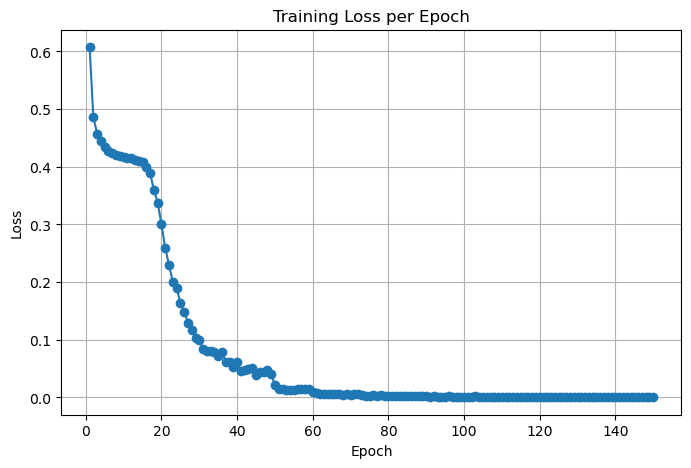


⏱️ Waktu training selesai dalam 11872.56 detik (197.88 menit)


In [18]:
if __name__ == '__main__':
    start_time = time.time()
    
    train()
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\n⏱️ Waktu training selesai dalam {elapsed_time:.2f} detik "
          f"({elapsed_time/60:.2f} menit)")

In [19]:
if __name__ == '__main__':
    start_time = time.time()
    
    evaluate_condition()
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\n⏱️ Waktu training selesai dalam {elapsed_time:.2f} detik "
          f"({elapsed_time/60:.2f} menit)")

100%|██████████████████████████████████████| 1099/1099 [00:05<00:00, 200.33it/s]


Rank-1 Accuracy (nm): 0.9818
Rank-5 Accuracy (nm): 0.9945

Rank-1 and Rank-5 Accuracy (nm) per angle:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 247.30it/s]


  Angle 0° - Rank-1: 0.9900, Rank-5: 0.9900


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 259.27it/s]


  Angle 18° - Rank-1: 1.0000, Rank-5: 1.0000


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 250.42it/s]


  Angle 36° - Rank-1: 0.9900, Rank-5: 1.0000


100%|██████████████████████████████████████████| 99/99 [00:00<00:00, 267.80it/s]


  Angle 54° - Rank-1: 0.9596, Rank-5: 0.9899


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 238.33it/s]


  Angle 72° - Rank-1: 0.9800, Rank-5: 0.9900


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 255.87it/s]


  Angle 90° - Rank-1: 0.9800, Rank-5: 1.0000


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 252.64it/s]


  Angle 108° - Rank-1: 0.9700, Rank-5: 1.0000


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 251.61it/s]


  Angle 126° - Rank-1: 1.0000, Rank-5: 1.0000


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 268.76it/s]


  Angle 144° - Rank-1: 0.9600, Rank-5: 0.9800


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 247.54it/s]


  Angle 162° - Rank-1: 0.9900, Rank-5: 0.9900


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 256.20it/s]


  Angle 180° - Rank-1: 0.9800, Rank-5: 1.0000


100%|██████████████████████████████████████| 1095/1095 [00:04<00:00, 234.19it/s]


Rank-1 Accuracy (bg): 0.7489
Rank-5 Accuracy (bg): 0.8740

Rank-1 and Rank-5 Accuracy (bg) per angle:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 171.43it/s]


  Angle 0° - Rank-1: 0.7100, Rank-5: 0.8500


100%|██████████████████████████████████████████| 99/99 [00:00<00:00, 259.76it/s]


  Angle 18° - Rank-1: 0.8283, Rank-5: 0.9091


100%|██████████████████████████████████████████| 99/99 [00:00<00:00, 254.39it/s]


  Angle 36° - Rank-1: 0.7374, Rank-5: 0.8788


100%|██████████████████████████████████████████| 98/98 [00:00<00:00, 246.76it/s]


  Angle 54° - Rank-1: 0.8163, Rank-5: 0.8776


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 217.02it/s]


  Angle 72° - Rank-1: 0.7800, Rank-5: 0.9000


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 256.57it/s]


  Angle 90° - Rank-1: 0.7300, Rank-5: 0.9000


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 249.41it/s]


  Angle 108° - Rank-1: 0.7200, Rank-5: 0.8600


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 275.37it/s]


  Angle 126° - Rank-1: 0.7200, Rank-5: 0.8900


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 274.85it/s]


  Angle 144° - Rank-1: 0.7700, Rank-5: 0.8700


100%|██████████████████████████████████████████| 99/99 [00:00<00:00, 263.05it/s]


  Angle 162° - Rank-1: 0.7071, Rank-5: 0.8384


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 271.93it/s]


  Angle 180° - Rank-1: 0.7200, Rank-5: 0.8400


100%|██████████████████████████████████████| 1100/1100 [00:04<00:00, 226.05it/s]


Rank-1 Accuracy (cl): 0.5273
Rank-5 Accuracy (cl): 0.7136

Rank-1 and Rank-5 Accuracy (cl) per angle:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 287.08it/s]


  Angle 0° - Rank-1: 0.4700, Rank-5: 0.6100


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 246.37it/s]


  Angle 18° - Rank-1: 0.5600, Rank-5: 0.7600


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 245.86it/s]


  Angle 36° - Rank-1: 0.4500, Rank-5: 0.6800


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 264.14it/s]


  Angle 54° - Rank-1: 0.5900, Rank-5: 0.7900


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 256.34it/s]


  Angle 72° - Rank-1: 0.6200, Rank-5: 0.8300


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 252.48it/s]


  Angle 90° - Rank-1: 0.5600, Rank-5: 0.7500


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 247.10it/s]


  Angle 108° - Rank-1: 0.5000, Rank-5: 0.7500


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 266.93it/s]


  Angle 126° - Rank-1: 0.5300, Rank-5: 0.7300


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 258.59it/s]


  Angle 144° - Rank-1: 0.5800, Rank-5: 0.7200


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 247.73it/s]


  Angle 162° - Rank-1: 0.4500, Rank-5: 0.6300


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 256.29it/s]


  Angle 180° - Rank-1: 0.4900, Rank-5: 0.6000

⏱️ Waktu training selesai dalam 41.08 detik (0.68 menit)


## 3.4 Model Dual Branch (Full GEI and Hard Mask GEI)

In [1]:
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import torch
import torchvision.transforms as transforms
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import os
from tqdm import tqdm
from pytorch_metric_learning import losses, miners

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ROOT_DIR = 'split_gei'
CSV_TRAIN = 'split_gei/train.csv'
CSV_TEST = 'split_gei/test.csv'

In [2]:
class GEIDatasetMultiInput(torch.utils.data.Dataset):
    def __init__(self, csv_file, gei_root, gei_masked_root, transform=None):
        self.df = pd.read_csv(csv_file)
        self.gei_root = gei_root
        self.gei_masked_root = gei_masked_root
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row['path']
        label = int(row['label'])

        full_img = Image.open(os.path.join(self.gei_root, path)).convert('L')
        masked_img = Image.open(os.path.join(self.gei_masked_root, path)).convert('L')

        if self.transform:
            full_img = self.transform(full_img)
            masked_img = self.transform(masked_img)

        return full_img, masked_img, label

# Contoh model multi-branch CNN
class MultiBranchGEINet(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        self.branch_full = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Flatten(),
            nn.Linear(10240, 256), nn.ReLU()
        )
        self.branch_masked = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Flatten(),
            nn.Linear(10240, 128), nn.ReLU()
        )

        self.fc = nn.Linear(256+128, embedding_dim)

    def forward(self, x_full, x_masked):
        out_full = self.branch_full(x_full)
        out_masked = self.branch_masked(x_masked)
        out = torch.cat([out_full, out_masked], dim=1)
        embedding = self.fc(out)
        return nn.functional.normalize(embedding, p=2, dim=1)

In [3]:
transform = transforms.Compose([
    transforms.Resize((128, 88)),
    transforms.ToTensor(),
])

train_dataset = GEIDatasetMultiInput(
    csv_file=CSV_TRAIN,
    gei_root=ROOT_DIR,
    gei_masked_root='split_gei_masked',
    transform=transform,
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model = MultiBranchGEINet(embedding_dim=256).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [4]:
def pairwise_distance(embeddings):
    # embeddings: [B, D]
    dot_product = torch.matmul(embeddings, embeddings.t())
    square_sum = torch.diag(dot_product)
    distances = square_sum.unsqueeze(1) - 2 * dot_product + square_sum.unsqueeze(0)
    distances = torch.clamp(distances, min=0.0)
    return distances

def batch_hard_triplet(embeddings, labels):
    distances = pairwise_distance(embeddings)  # [B, B]
    mask_pos = labels.unsqueeze(1) == labels.unsqueeze(0)  # Positive mask
    mask_neg = labels.unsqueeze(1) != labels.unsqueeze(0)  # Negative mask

    # For each anchor, hardest positive (max distance)
    hardest_pos_dist, _ = (distances * mask_pos.float()).max(dim=1)
    # For each anchor, hardest negative (min distance, positive inf replaced)
    max_dist = distances.max().item()
    distances_neg = distances + max_dist * mask_pos.float()
    hardest_neg_dist, _ = distances_neg.min(dim=1)

    return hardest_pos_dist, hardest_neg_dist

Epoch 1/150: 100%|████████████████████████████| 252/252 [02:23<00:00,  1.76it/s]


Epoch 1: Loss = 0.2995
Last LR from scheduler: [0.001]


Epoch 2/150: 100%|████████████████████████████| 252/252 [02:36<00:00,  1.61it/s]


Epoch 2: Loss = 0.2992
Last LR from scheduler: [0.001]


Epoch 3/150: 100%|████████████████████████████| 252/252 [02:42<00:00,  1.55it/s]


Epoch 3: Loss = 0.2986
Last LR from scheduler: [0.001]


Epoch 4/150: 100%|████████████████████████████| 252/252 [02:46<00:00,  1.52it/s]


Epoch 4: Loss = 0.2805
Last LR from scheduler: [0.001]


Epoch 5/150: 100%|████████████████████████████| 252/252 [02:47<00:00,  1.51it/s]


Epoch 5: Loss = 0.2026
Last LR from scheduler: [0.001]


Epoch 6/150: 100%|████████████████████████████| 252/252 [02:48<00:00,  1.49it/s]


Epoch 6: Loss = 0.1529
Last LR from scheduler: [0.001]


Epoch 7/150: 100%|████████████████████████████| 252/252 [02:49<00:00,  1.49it/s]


Epoch 7: Loss = 0.1296
Last LR from scheduler: [0.001]


Epoch 8/150: 100%|████████████████████████████| 252/252 [03:00<00:00,  1.40it/s]


Epoch 8: Loss = 0.1200
Last LR from scheduler: [0.001]


Epoch 9/150: 100%|████████████████████████████| 252/252 [02:54<00:00,  1.44it/s]


Epoch 9: Loss = 0.1097
Last LR from scheduler: [0.001]


Epoch 10/150: 100%|███████████████████████████| 252/252 [02:54<00:00,  1.44it/s]


Epoch 10: Loss = 0.0989
Last LR from scheduler: [0.001]


Epoch 11/150: 100%|███████████████████████████| 252/252 [02:52<00:00,  1.46it/s]


Epoch 11: Loss = 0.0922
Last LR from scheduler: [0.001]


Epoch 12/150: 100%|███████████████████████████| 252/252 [02:50<00:00,  1.48it/s]


Epoch 12: Loss = 0.0765
Last LR from scheduler: [0.001]


Epoch 13/150: 100%|███████████████████████████| 252/252 [02:56<00:00,  1.42it/s]


Epoch 13: Loss = 0.0674
Last LR from scheduler: [0.001]


Epoch 14/150: 100%|███████████████████████████| 252/252 [03:02<00:00,  1.38it/s]


Epoch 14: Loss = 0.0645
Last LR from scheduler: [0.001]


Epoch 15/150: 100%|███████████████████████████| 252/252 [03:06<00:00,  1.35it/s]


Epoch 15: Loss = 0.0515
Last LR from scheduler: [0.001]


Epoch 16/150: 100%|███████████████████████████| 252/252 [03:06<00:00,  1.35it/s]


Epoch 16: Loss = 0.0489
Last LR from scheduler: [0.001]


Epoch 17/150: 100%|███████████████████████████| 252/252 [03:08<00:00,  1.34it/s]


Epoch 17: Loss = 0.0409
Last LR from scheduler: [0.001]


Epoch 18/150: 100%|███████████████████████████| 252/252 [03:10<00:00,  1.33it/s]


Epoch 18: Loss = 0.0405
Last LR from scheduler: [0.001]


Epoch 19/150: 100%|███████████████████████████| 252/252 [03:09<00:00,  1.33it/s]


Epoch 19: Loss = 0.0352
Last LR from scheduler: [0.001]


Epoch 20/150: 100%|███████████████████████████| 252/252 [03:10<00:00,  1.32it/s]


Epoch 20: Loss = 0.0314
Last LR from scheduler: [0.001]


Epoch 21/150: 100%|███████████████████████████| 252/252 [03:11<00:00,  1.31it/s]


Epoch 21: Loss = 0.0256
Last LR from scheduler: [0.001]


Epoch 22/150: 100%|███████████████████████████| 252/252 [03:13<00:00,  1.30it/s]


Epoch 22: Loss = 0.0227
Last LR from scheduler: [0.001]


Epoch 23/150: 100%|███████████████████████████| 252/252 [03:15<00:00,  1.29it/s]


Epoch 23: Loss = 0.0224
Last LR from scheduler: [0.001]


Epoch 24/150: 100%|███████████████████████████| 252/252 [03:12<00:00,  1.31it/s]


Epoch 24: Loss = 0.0188
Last LR from scheduler: [0.001]


Epoch 25/150: 100%|███████████████████████████| 252/252 [03:12<00:00,  1.31it/s]


Epoch 25: Loss = 0.0171
Last LR from scheduler: [0.001]


Epoch 26/150: 100%|███████████████████████████| 252/252 [03:11<00:00,  1.31it/s]


Epoch 26: Loss = 0.0163
Last LR from scheduler: [0.001]


Epoch 27/150: 100%|███████████████████████████| 252/252 [03:11<00:00,  1.31it/s]


Epoch 27: Loss = 0.0132
Last LR from scheduler: [0.001]


Epoch 28/150: 100%|███████████████████████████| 252/252 [03:17<00:00,  1.28it/s]


Epoch 28: Loss = 0.0133
Last LR from scheduler: [0.001]


Epoch 29/150: 100%|███████████████████████████| 252/252 [03:12<00:00,  1.31it/s]


Epoch 29: Loss = 0.0149
Last LR from scheduler: [0.001]


Epoch 30/150: 100%|███████████████████████████| 252/252 [03:08<00:00,  1.34it/s]


Epoch 30: Loss = 0.0126
Last LR from scheduler: [0.001]


Epoch 31/150: 100%|███████████████████████████| 252/252 [03:11<00:00,  1.32it/s]


Epoch 31: Loss = 0.0104
Last LR from scheduler: [0.001]


Epoch 32/150: 100%|███████████████████████████| 252/252 [03:12<00:00,  1.31it/s]


Epoch 32: Loss = 0.0103
Last LR from scheduler: [0.001]


Epoch 33/150: 100%|███████████████████████████| 252/252 [03:10<00:00,  1.32it/s]


Epoch 33: Loss = 0.0094
Last LR from scheduler: [0.001]


Epoch 34/150: 100%|███████████████████████████| 252/252 [03:09<00:00,  1.33it/s]


Epoch 34: Loss = 0.0092
Last LR from scheduler: [0.001]


Epoch 35/150: 100%|███████████████████████████| 252/252 [03:09<00:00,  1.33it/s]


Epoch 35: Loss = 0.0075
Last LR from scheduler: [0.001]


Epoch 36/150: 100%|███████████████████████████| 252/252 [03:04<00:00,  1.37it/s]


Epoch 36: Loss = 0.0053
Last LR from scheduler: [0.001]


Epoch 37/150: 100%|███████████████████████████| 252/252 [03:11<00:00,  1.32it/s]


Epoch 37: Loss = 0.0081
Last LR from scheduler: [0.001]


Epoch 38/150: 100%|███████████████████████████| 252/252 [03:32<00:00,  1.19it/s]


Epoch 38: Loss = 0.0063
Last LR from scheduler: [0.001]


Epoch 39/150: 100%|███████████████████████████| 252/252 [03:34<00:00,  1.17it/s]


Epoch 39: Loss = 0.0057
Last LR from scheduler: [0.001]


Epoch 40/150: 100%|███████████████████████████| 252/252 [03:12<00:00,  1.31it/s]


Epoch 40: Loss = 0.0051
Last LR from scheduler: [0.001]


Epoch 41/150: 100%|███████████████████████████| 252/252 [03:11<00:00,  1.32it/s]


Epoch 41: Loss = 0.0064
Last LR from scheduler: [0.001]


Epoch 42/150: 100%|███████████████████████████| 252/252 [03:12<00:00,  1.31it/s]


Epoch 42: Loss = 0.0067
Last LR from scheduler: [0.001]


Epoch 43/150: 100%|███████████████████████████| 252/252 [03:02<00:00,  1.38it/s]


Epoch 43: Loss = 0.0045
Last LR from scheduler: [0.001]


Epoch 44/150: 100%|███████████████████████████| 252/252 [02:56<00:00,  1.43it/s]


Epoch 44: Loss = 0.0054
Last LR from scheduler: [0.001]


Epoch 45/150: 100%|███████████████████████████| 252/252 [03:03<00:00,  1.38it/s]


Epoch 45: Loss = 0.0065
Last LR from scheduler: [0.001]


Epoch 46/150: 100%|███████████████████████████| 252/252 [03:05<00:00,  1.36it/s]


Epoch 46: Loss = 0.0058
Last LR from scheduler: [0.001]


Epoch 47/150: 100%|███████████████████████████| 252/252 [02:54<00:00,  1.44it/s]


Epoch 47: Loss = 0.0056
Last LR from scheduler: [0.0005]


Epoch 48/150: 100%|███████████████████████████| 252/252 [02:58<00:00,  1.41it/s]


Epoch 48: Loss = 0.0023
Last LR from scheduler: [0.0005]


Epoch 49/150: 100%|███████████████████████████| 252/252 [03:05<00:00,  1.36it/s]


Epoch 49: Loss = 0.0015
Last LR from scheduler: [0.0005]


Epoch 50/150: 100%|███████████████████████████| 252/252 [03:04<00:00,  1.37it/s]


Epoch 50: Loss = 0.0014
Last LR from scheduler: [0.0005]


Epoch 51/150: 100%|███████████████████████████| 252/252 [02:57<00:00,  1.42it/s]


Epoch 51: Loss = 0.0012
Last LR from scheduler: [0.0005]


Epoch 52/150: 100%|███████████████████████████| 252/252 [03:09<00:00,  1.33it/s]


Epoch 52: Loss = 0.0012
Last LR from scheduler: [0.0005]


Epoch 53/150: 100%|███████████████████████████| 252/252 [03:12<00:00,  1.31it/s]


Epoch 53: Loss = 0.0013
Last LR from scheduler: [0.0005]


Epoch 54/150: 100%|███████████████████████████| 252/252 [03:15<00:00,  1.29it/s]


Epoch 54: Loss = 0.0009
Last LR from scheduler: [0.0005]


Epoch 55/150: 100%|███████████████████████████| 252/252 [03:24<00:00,  1.23it/s]


Epoch 55: Loss = 0.0008
Last LR from scheduler: [0.0005]


Epoch 56/150: 100%|███████████████████████████| 252/252 [03:21<00:00,  1.25it/s]


Epoch 56: Loss = 0.0014
Last LR from scheduler: [0.0005]


Epoch 57/150: 100%|███████████████████████████| 252/252 [03:23<00:00,  1.24it/s]


Epoch 57: Loss = 0.0014
Last LR from scheduler: [0.0005]


Epoch 58/150: 100%|███████████████████████████| 252/252 [03:15<00:00,  1.29it/s]


Epoch 58: Loss = 0.0011
Last LR from scheduler: [0.0005]


Epoch 59/150: 100%|███████████████████████████| 252/252 [03:17<00:00,  1.27it/s]


Epoch 59: Loss = 0.0012
Last LR from scheduler: [0.00025]


Epoch 60/150: 100%|███████████████████████████| 252/252 [03:17<00:00,  1.28it/s]


Epoch 60: Loss = 0.0005
Last LR from scheduler: [0.00025]


Epoch 61/150: 100%|███████████████████████████| 252/252 [03:11<00:00,  1.31it/s]


Epoch 61: Loss = 0.0004
Last LR from scheduler: [0.00025]


Epoch 62/150: 100%|███████████████████████████| 252/252 [03:08<00:00,  1.34it/s]


Epoch 62: Loss = 0.0005
Last LR from scheduler: [0.00025]


Epoch 63/150: 100%|███████████████████████████| 252/252 [03:12<00:00,  1.31it/s]


Epoch 63: Loss = 0.0003
Last LR from scheduler: [0.00025]


Epoch 64/150: 100%|███████████████████████████| 252/252 [03:14<00:00,  1.29it/s]


Epoch 64: Loss = 0.0005
Last LR from scheduler: [0.00025]


Epoch 65/150: 100%|███████████████████████████| 252/252 [03:12<00:00,  1.31it/s]


Epoch 65: Loss = 0.0006
Last LR from scheduler: [0.00025]


Epoch 66/150: 100%|███████████████████████████| 252/252 [03:02<00:00,  1.38it/s]


Epoch 66: Loss = 0.0005
Last LR from scheduler: [0.00025]


Epoch 67/150: 100%|███████████████████████████| 252/252 [02:56<00:00,  1.43it/s]


Epoch 67: Loss = 0.0006
Last LR from scheduler: [0.000125]


Epoch 68/150: 100%|███████████████████████████| 252/252 [02:55<00:00,  1.44it/s]


Epoch 68: Loss = 0.0003
Last LR from scheduler: [0.000125]


Epoch 69/150: 100%|███████████████████████████| 252/252 [02:57<00:00,  1.42it/s]


Epoch 69: Loss = 0.0003
Last LR from scheduler: [0.000125]


Epoch 70/150: 100%|███████████████████████████| 252/252 [02:57<00:00,  1.42it/s]


Epoch 70: Loss = 0.0004
Last LR from scheduler: [0.000125]


Epoch 71/150: 100%|███████████████████████████| 252/252 [02:57<00:00,  1.42it/s]


Epoch 71: Loss = 0.0002
Last LR from scheduler: [0.000125]


Epoch 72/150: 100%|███████████████████████████| 252/252 [02:58<00:00,  1.41it/s]


Epoch 72: Loss = 0.0002
Last LR from scheduler: [0.000125]


Epoch 73/150: 100%|███████████████████████████| 252/252 [02:59<00:00,  1.40it/s]


Epoch 73: Loss = 0.0003
Last LR from scheduler: [0.000125]


Epoch 74/150: 100%|███████████████████████████| 252/252 [02:59<00:00,  1.41it/s]


Epoch 74: Loss = 0.0002
Last LR from scheduler: [0.000125]


Epoch 75/150: 100%|███████████████████████████| 252/252 [02:59<00:00,  1.40it/s]


Epoch 75: Loss = 0.0002
Last LR from scheduler: [6.25e-05]


Epoch 76/150: 100%|███████████████████████████| 252/252 [03:02<00:00,  1.38it/s]


Epoch 76: Loss = 0.0001
Last LR from scheduler: [6.25e-05]


Epoch 77/150: 100%|███████████████████████████| 252/252 [03:12<00:00,  1.31it/s]


Epoch 77: Loss = 0.0001
Last LR from scheduler: [6.25e-05]


Epoch 78/150: 100%|███████████████████████████| 252/252 [03:28<00:00,  1.21it/s]


Epoch 78: Loss = 0.0002
Last LR from scheduler: [6.25e-05]


Epoch 79/150: 100%|███████████████████████████| 252/252 [03:30<00:00,  1.20it/s]


Epoch 79: Loss = 0.0003
Last LR from scheduler: [6.25e-05]


Epoch 80/150: 100%|███████████████████████████| 252/252 [03:31<00:00,  1.19it/s]


Epoch 80: Loss = 0.0001
Last LR from scheduler: [6.25e-05]


Epoch 81/150: 100%|███████████████████████████| 252/252 [03:18<00:00,  1.27it/s]


Epoch 81: Loss = 0.0001
Last LR from scheduler: [3.125e-05]


Epoch 82/150: 100%|███████████████████████████| 252/252 [02:52<00:00,  1.46it/s]


Epoch 82: Loss = 0.0001
Last LR from scheduler: [3.125e-05]


Epoch 83/150: 100%|███████████████████████████| 252/252 [02:50<00:00,  1.48it/s]


Epoch 83: Loss = 0.0000
Last LR from scheduler: [3.125e-05]


Epoch 84/150: 100%|███████████████████████████| 252/252 [02:49<00:00,  1.49it/s]


Epoch 84: Loss = 0.0001
Last LR from scheduler: [3.125e-05]


Epoch 85/150: 100%|███████████████████████████| 252/252 [02:48<00:00,  1.50it/s]


Epoch 85: Loss = 0.0001
Last LR from scheduler: [3.125e-05]


Epoch 86/150: 100%|███████████████████████████| 252/252 [02:50<00:00,  1.47it/s]


Epoch 86: Loss = 0.0000
Last LR from scheduler: [3.125e-05]


Epoch 87/150: 100%|███████████████████████████| 252/252 [02:50<00:00,  1.47it/s]


Epoch 87: Loss = 0.0002
Last LR from scheduler: [3.125e-05]


Epoch 88/150: 100%|███████████████████████████| 252/252 [02:50<00:00,  1.47it/s]


Epoch 88: Loss = 0.0001
Last LR from scheduler: [3.125e-05]


Epoch 89/150: 100%|███████████████████████████| 252/252 [02:50<00:00,  1.48it/s]


Epoch 89: Loss = 0.0001
Last LR from scheduler: [3.125e-05]


Epoch 90/150: 100%|███████████████████████████| 252/252 [02:50<00:00,  1.48it/s]


Epoch 90: Loss = 0.0001
Last LR from scheduler: [1.5625e-05]


Epoch 91/150: 100%|███████████████████████████| 252/252 [02:51<00:00,  1.47it/s]


Epoch 91: Loss = 0.0000
Last LR from scheduler: [1.5625e-05]


Epoch 92/150: 100%|███████████████████████████| 252/252 [02:53<00:00,  1.45it/s]


Epoch 92: Loss = 0.0001
Last LR from scheduler: [1.5625e-05]


Epoch 93/150: 100%|███████████████████████████| 252/252 [02:52<00:00,  1.46it/s]


Epoch 93: Loss = 0.0000
Last LR from scheduler: [1.5625e-05]


Epoch 94/150: 100%|███████████████████████████| 252/252 [02:52<00:00,  1.46it/s]


Epoch 94: Loss = 0.0001
Last LR from scheduler: [1.5625e-05]


Epoch 95/150: 100%|███████████████████████████| 252/252 [02:52<00:00,  1.46it/s]


Epoch 95: Loss = 0.0000
Last LR from scheduler: [7.8125e-06]


Epoch 96/150: 100%|███████████████████████████| 252/252 [02:53<00:00,  1.46it/s]


Epoch 96: Loss = 0.0001
Last LR from scheduler: [7.8125e-06]


Epoch 97/150: 100%|███████████████████████████| 252/252 [02:53<00:00,  1.45it/s]


Epoch 97: Loss = 0.0000
Last LR from scheduler: [7.8125e-06]


Epoch 98/150: 100%|███████████████████████████| 252/252 [02:53<00:00,  1.45it/s]


Epoch 98: Loss = 0.0001
Last LR from scheduler: [7.8125e-06]


Epoch 99/150: 100%|███████████████████████████| 252/252 [02:53<00:00,  1.45it/s]


Epoch 99: Loss = 0.0000
Last LR from scheduler: [3.90625e-06]


Epoch 100/150: 100%|██████████████████████████| 252/252 [02:53<00:00,  1.45it/s]


Epoch 100: Loss = 0.0000
Last LR from scheduler: [3.90625e-06]


Epoch 101/150: 100%|██████████████████████████| 252/252 [02:53<00:00,  1.45it/s]


Epoch 101: Loss = 0.0000
Last LR from scheduler: [3.90625e-06]


Epoch 102/150: 100%|██████████████████████████| 252/252 [02:52<00:00,  1.46it/s]


Epoch 102: Loss = 0.0001
Last LR from scheduler: [3.90625e-06]


Epoch 103/150: 100%|██████████████████████████| 252/252 [02:53<00:00,  1.45it/s]


Epoch 103: Loss = 0.0001
Last LR from scheduler: [1.953125e-06]


Epoch 104/150: 100%|██████████████████████████| 252/252 [02:53<00:00,  1.45it/s]


Epoch 104: Loss = 0.0001
Last LR from scheduler: [1.953125e-06]


Epoch 105/150: 100%|██████████████████████████| 252/252 [02:53<00:00,  1.45it/s]


Epoch 105: Loss = 0.0000
Last LR from scheduler: [1.953125e-06]


Epoch 106/150: 100%|██████████████████████████| 252/252 [02:53<00:00,  1.46it/s]


Epoch 106: Loss = 0.0000
Last LR from scheduler: [1.953125e-06]


Epoch 107/150: 100%|██████████████████████████| 252/252 [02:53<00:00,  1.45it/s]


Epoch 107: Loss = 0.0001
Last LR from scheduler: [9.765625e-07]


Epoch 108/150: 100%|██████████████████████████| 252/252 [02:53<00:00,  1.45it/s]


Epoch 108: Loss = 0.0000
Last LR from scheduler: [9.765625e-07]


Epoch 109/150: 100%|██████████████████████████| 252/252 [02:53<00:00,  1.45it/s]


Epoch 109: Loss = 0.0001
Last LR from scheduler: [9.765625e-07]


Epoch 110/150: 100%|██████████████████████████| 252/252 [02:53<00:00,  1.45it/s]


Epoch 110: Loss = 0.0001
Last LR from scheduler: [9.765625e-07]


Epoch 111/150: 100%|██████████████████████████| 252/252 [02:53<00:00,  1.46it/s]


Epoch 111: Loss = 0.0001
Last LR from scheduler: [9.765625e-07]


Epoch 112/150: 100%|██████████████████████████| 252/252 [02:53<00:00,  1.45it/s]


Epoch 112: Loss = 0.0000
Last LR from scheduler: [4.8828125e-07]


Epoch 113/150: 100%|██████████████████████████| 252/252 [02:53<00:00,  1.45it/s]


Epoch 113: Loss = 0.0000
Last LR from scheduler: [4.8828125e-07]


Epoch 114/150: 100%|██████████████████████████| 252/252 [02:53<00:00,  1.45it/s]


Epoch 114: Loss = 0.0000
Last LR from scheduler: [4.8828125e-07]


Epoch 115/150: 100%|██████████████████████████| 252/252 [02:52<00:00,  1.46it/s]


Epoch 115: Loss = 0.0000
Last LR from scheduler: [4.8828125e-07]


Epoch 116/150: 100%|██████████████████████████| 252/252 [02:53<00:00,  1.46it/s]


Epoch 116: Loss = 0.0000
Last LR from scheduler: [4.8828125e-07]


Epoch 117/150: 100%|██████████████████████████| 252/252 [02:52<00:00,  1.46it/s]


Epoch 117: Loss = 0.0000
Last LR from scheduler: [2.44140625e-07]


Epoch 118/150: 100%|██████████████████████████| 252/252 [02:53<00:00,  1.46it/s]


Epoch 118: Loss = 0.0000
Last LR from scheduler: [2.44140625e-07]


Epoch 119/150: 100%|██████████████████████████| 252/252 [02:52<00:00,  1.46it/s]


Epoch 119: Loss = 0.0000
Last LR from scheduler: [2.44140625e-07]


Epoch 120/150: 100%|██████████████████████████| 252/252 [02:52<00:00,  1.46it/s]


Epoch 120: Loss = 0.0001
Last LR from scheduler: [2.44140625e-07]


Epoch 121/150: 100%|██████████████████████████| 252/252 [02:52<00:00,  1.46it/s]


Epoch 121: Loss = 0.0000
Last LR from scheduler: [2.44140625e-07]


Epoch 122/150: 100%|██████████████████████████| 252/252 [02:52<00:00,  1.46it/s]


Epoch 122: Loss = 0.0001
Last LR from scheduler: [2.44140625e-07]


Epoch 123/150: 100%|██████████████████████████| 252/252 [02:50<00:00,  1.48it/s]


Epoch 123: Loss = 0.0001
Last LR from scheduler: [1.220703125e-07]


Epoch 124/150: 100%|██████████████████████████| 252/252 [02:50<00:00,  1.48it/s]


Epoch 124: Loss = 0.0001
Last LR from scheduler: [1.220703125e-07]


Epoch 125/150: 100%|██████████████████████████| 252/252 [02:50<00:00,  1.48it/s]


Epoch 125: Loss = 0.0000
Last LR from scheduler: [1.220703125e-07]


Epoch 126/150: 100%|██████████████████████████| 252/252 [02:51<00:00,  1.47it/s]


Epoch 126: Loss = 0.0000
Last LR from scheduler: [1.220703125e-07]


Epoch 127/150: 100%|██████████████████████████| 252/252 [02:52<00:00,  1.46it/s]


Epoch 127: Loss = 0.0001
Last LR from scheduler: [6.103515625e-08]


Epoch 128/150: 100%|██████████████████████████| 252/252 [02:52<00:00,  1.46it/s]


Epoch 128: Loss = 0.0000
Last LR from scheduler: [6.103515625e-08]


Epoch 129/150: 100%|██████████████████████████| 252/252 [02:52<00:00,  1.46it/s]


Epoch 129: Loss = 0.0001
Last LR from scheduler: [6.103515625e-08]


Epoch 130/150: 100%|██████████████████████████| 252/252 [02:52<00:00,  1.46it/s]


Epoch 130: Loss = 0.0000
Last LR from scheduler: [6.103515625e-08]


Epoch 131/150: 100%|██████████████████████████| 252/252 [02:53<00:00,  1.46it/s]


Epoch 131: Loss = 0.0000
Last LR from scheduler: [3.0517578125e-08]


Epoch 132/150: 100%|██████████████████████████| 252/252 [02:54<00:00,  1.44it/s]


Epoch 132: Loss = 0.0000
Last LR from scheduler: [3.0517578125e-08]


Epoch 133/150: 100%|██████████████████████████| 252/252 [02:52<00:00,  1.46it/s]


Epoch 133: Loss = 0.0001
Last LR from scheduler: [3.0517578125e-08]


Epoch 134/150: 100%|██████████████████████████| 252/252 [02:52<00:00,  1.46it/s]


Epoch 134: Loss = 0.0000
Last LR from scheduler: [3.0517578125e-08]


Epoch 135/150: 100%|██████████████████████████| 252/252 [02:52<00:00,  1.46it/s]


Epoch 135: Loss = 0.0000
Last LR from scheduler: [3.0517578125e-08]


Epoch 136/150: 100%|██████████████████████████| 252/252 [02:52<00:00,  1.46it/s]


Epoch 136: Loss = 0.0001
Last LR from scheduler: [3.0517578125e-08]


Epoch 137/150: 100%|██████████████████████████| 252/252 [02:52<00:00,  1.46it/s]


Epoch 137: Loss = 0.0000
Last LR from scheduler: [3.0517578125e-08]


Epoch 138/150: 100%|██████████████████████████| 252/252 [02:53<00:00,  1.46it/s]


Epoch 138: Loss = 0.0000
Last LR from scheduler: [3.0517578125e-08]


Epoch 139/150: 100%|██████████████████████████| 252/252 [02:54<00:00,  1.44it/s]


Epoch 139: Loss = 0.0001
Last LR from scheduler: [1.52587890625e-08]


Epoch 140/150: 100%|██████████████████████████| 252/252 [02:54<00:00,  1.45it/s]


Epoch 140: Loss = 0.0000
Last LR from scheduler: [1.52587890625e-08]


Epoch 141/150: 100%|██████████████████████████| 252/252 [02:54<00:00,  1.44it/s]


Epoch 141: Loss = 0.0001
Last LR from scheduler: [1.52587890625e-08]


Epoch 142/150: 100%|██████████████████████████| 252/252 [02:54<00:00,  1.45it/s]


Epoch 142: Loss = 0.0001
Last LR from scheduler: [1.52587890625e-08]


Epoch 143/150: 100%|██████████████████████████| 252/252 [02:54<00:00,  1.44it/s]


Epoch 143: Loss = 0.0000
Last LR from scheduler: [1.52587890625e-08]


Epoch 144/150: 100%|██████████████████████████| 252/252 [02:55<00:00,  1.43it/s]


Epoch 144: Loss = 0.0000
Last LR from scheduler: [1.52587890625e-08]


Epoch 145/150: 100%|██████████████████████████| 252/252 [02:56<00:00,  1.43it/s]


Epoch 145: Loss = 0.0001
Last LR from scheduler: [1.52587890625e-08]


Epoch 146/150: 100%|██████████████████████████| 252/252 [02:55<00:00,  1.43it/s]


Epoch 146: Loss = 0.0001
Last LR from scheduler: [1.52587890625e-08]


Epoch 147/150: 100%|██████████████████████████| 252/252 [02:55<00:00,  1.43it/s]


Epoch 147: Loss = 0.0001
Last LR from scheduler: [1.52587890625e-08]


Epoch 148/150: 100%|██████████████████████████| 252/252 [02:55<00:00,  1.43it/s]


Epoch 148: Loss = 0.0000
Last LR from scheduler: [1.52587890625e-08]


Epoch 149/150: 100%|██████████████████████████| 252/252 [02:57<00:00,  1.42it/s]


Epoch 149: Loss = 0.0000
Last LR from scheduler: [1.52587890625e-08]


Epoch 150/150: 100%|██████████████████████████| 252/252 [02:58<00:00,  1.42it/s]


Epoch 150: Loss = 0.0000
Last LR from scheduler: [1.52587890625e-08]

⏱️ Waktu training selesai dalam 27049.37 detik (450.82 menit)
Model saved to multi_branch_geinet.pth


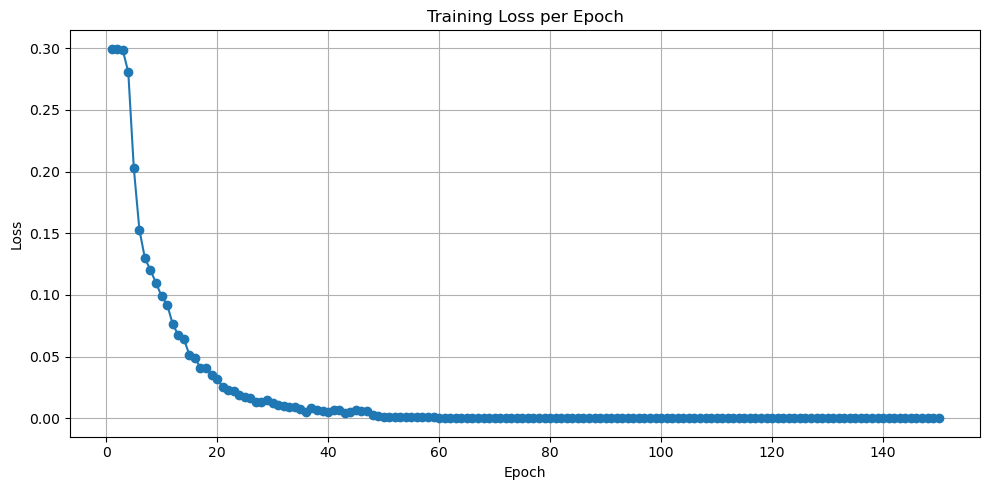

In [5]:
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import time

EPOCHS = 150
ROOT_DIR = 'split_gei'
margin = 0.3  # Margin untuk triplet loss

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

model.train()
loss_history = []

start_time = time.time()
for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for x_full, x_masked, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x_full = x_full.to(DEVICE)
        x_masked = x_masked.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        embeddings = model(x_full, x_masked)

        # Batch-hard triplet mining
        pos_dist, neg_dist = batch_hard_triplet(embeddings, labels)

        # Triplet loss
        loss = F.relu(pos_dist - neg_dist + margin).mean()

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)  # Simpan loss tiap epoch

    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")
    scheduler.step(avg_loss)
    print(f"Last LR from scheduler: {scheduler.get_last_lr()}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\n⏱️ Waktu training selesai dalam {elapsed_time:.2f} detik "
      f"({elapsed_time/60:.2f} menit)")

# Simpan model
torch.save(model.state_dict(), 'multi_branch_geinet.pth')
print("Model saved to multi_branch_geinet.pth")

# --- Plot Loss Curve ---
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), loss_history, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.grid(True)
plt.tight_layout()
plt.savefig("training_loss_curve.png")  # Optional: Simpan grafik
plt.show()

In [6]:
import pandas as pd
from torch.utils.data import DataLoader, Subset
import os

# Dataset multi-input yang output condition juga
class GEIDatasetWithCondition(torch.utils.data.Dataset):
    def __init__(self, csv_file, gei_root, gei_masked_root, transform=None):
        self.df = pd.read_csv(csv_file)
        self.gei_root = gei_root
        self.gei_masked_root = gei_masked_root
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row['path']
        label = int(row['label'])
        condition = row['condition']
        angle = row['angle']  # pastikan ini kolom sudut, e.g. '000', '090', dst

        # pastikan ini bertipe string atau integer sesuai evaluasi nanti
        if isinstance(angle, str):
            angle = angle.strip()  # hapus spasi kalau ada

        full_img = Image.open(os.path.join(self.gei_root, path)).convert('L')
        masked_img = Image.open(os.path.join(self.gei_masked_root, path)).convert('L')

        if self.transform:
            full_img = self.transform(full_img)
            masked_img = self.transform(masked_img)
            
        return full_img, masked_img, label, condition, angle

# Fungsi buat subset dari dataset berdasarkan kondisi
def create_subset_loader(dataset, conditions_filter, batch_size=32, shuffle=False):
    idxs = [i for i, row in dataset.df.iterrows() if row['condition'] in conditions_filter]
    subset = Subset(dataset, idxs)
    loader = DataLoader(subset, batch_size=batch_size, shuffle=shuffle)
    return loader

In [7]:
import numpy as np
import torch
from collections import defaultdict

def compute_embeddings(dataloader, model, device=DEVICE):
    model.eval()
    all_embeddings = []
    all_labels = []
    all_conditions = []
    all_angles = []

    with torch.no_grad():
        for x_full, x_masked, labels, conditions, angles in dataloader:
            x_full = x_full.to(device)
            x_masked = x_masked.to(device)
            labels = labels.to(device)
            angles = angles.to(device)  # meskipun nanti kita konversi ke numpy

            # conditions adalah tuple of strings → ubah ke list dan parse
            condition_codes = [c.split('-')[0].lower() for c in conditions]
            condition_map = {'nm': 0, 'bg': 1, 'cl': 2}
            conditions_tensor = torch.tensor(
                [condition_map.get(c, -1) for c in condition_codes],
                dtype=torch.long
            ).to(device)

            # Forward pass ke model (multi-branch)
            embeddings = model(x_full, x_masked)
            all_embeddings.append(embeddings.cpu())

            all_labels.extend(labels.cpu().tolist())
            all_conditions.extend(conditions)
            all_angles.extend(angles.cpu().tolist())

    all_embeddings = torch.cat(all_embeddings, dim=0).numpy()
    return (
        all_embeddings,
        np.array(all_labels),
        np.array(all_conditions),
        np.array(all_angles)
    )

@torch.no_grad()
def rank_k_accuracy(dist_mat, labels_gallery, labels_probe, k=1):
    correct = 0
    for i in range(len(labels_probe)):
        # urutkan jarak dari terkecil ke terbesar
        sorted_indices = np.argsort(dist_mat[i])
        # cek apakah label probe ada di top-k gallery
        if labels_probe[i] in labels_gallery[sorted_indices[:k]]:
            correct += 1
    return correct / len(labels_probe)

def map_condition_to_group(condition):
    condition = condition.lower()
    if condition.startswith('nm'):
        return 'NM'
    elif condition.startswith('bg'):
        return 'BG'
    elif condition.startswith('cl'):
        return 'CL'
    else:
        return 'Other'

@torch.no_grad()
def evaluate_rank_k_grouped(model, gallery_loader, probe_loader, device, k_list=[1,5]):
    start_time = time.time()
    gallery_emb, gallery_lbl, gallery_cond, gallery_angles = compute_embeddings(gallery_loader, model)
    probe_emb, probe_lbl, probe_cond, probe_angles = compute_embeddings(probe_loader, model)

    # Hitung distance matrix probe ke gallery
    dist_mat = np.linalg.norm(probe_emb[:, None, :] - gallery_emb[None, :, :], axis=2)

    # Map kondisi ke grup
    probe_groups = np.array([map_condition_to_group(c) for c in probe_cond])

    results = defaultdict(dict)

    # Unique groups
    unique_groups = np.unique(probe_groups)

    for group in unique_groups:
        idxs = np.where(probe_groups == group)[0]
        group_dist = dist_mat[idxs]
        group_probe_lbl = probe_lbl[idxs]
        group_probe_angles = probe_angles[idxs]

        for k in k_list:
            acc = rank_k_accuracy(group_dist, gallery_lbl, group_probe_lbl, k)
            results[group][f'Rank@{k}'] = acc

        # Per-angle Rank-1 (hanya untuk k=1)
        angle_ranks = {}
        for angle in sorted(set(group_probe_angles)):
            angle_idxs = idxs[group_probe_angles == angle]
            if len(angle_idxs) == 0:
                continue
            angle_dist = dist_mat[angle_idxs]
            angle_lbls = probe_lbl[angle_idxs]
            acc = rank_k_accuracy(angle_dist, gallery_lbl, angle_lbls, k=1)
            angle_ranks[angle] = acc

        results[group]['AngleDetail'] = angle_ranks

    # Print hasil
    for group in ['NM', 'BG', 'CL']:
        if group in results:
            print(f"Group: {group}")
            for k in k_list:
                print(f"  Rank@{k}: {results[group][f'Rank@{k}']:.4f}")
            print("  Rank@1 per Angle:")
            for angle, acc in results[group]['AngleDetail'].items():
                print(f"    Angle {angle:>3}: {acc:.4f}")
            print()
        else:
            print(f"Group: {group} - no data\n")

            
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\n⏱️ Waktu evaluasi selesai dalam {elapsed_time:.2f} detik "
          f"({elapsed_time/60:.2f} menit)")
    
    return results


In [8]:
# Contoh pemakaian
transform = transforms.Compose([
    transforms.Resize((128, 88)),
    transforms.ToTensor(),
])

gei_root = 'split_gei'
gei_masked_root = 'split_gei_masked'

full_dataset = GEIDatasetWithCondition(CSV_TEST, gei_root, gei_masked_root, transform)

# Gallery dan probe sesuai keinginanmu
gallery_conditions = ['nm-01', 'nm-02', 'nm-03', 'nm-04']
probe_conditions = ['nm-05', 'nm-06', 'bg-01', 'bg-02', 'cl-01', 'cl-02']

gallery_loader = create_subset_loader(full_dataset, gallery_conditions, batch_size=32, shuffle=False)
probe_loader = create_subset_loader(full_dataset, probe_conditions, batch_size=32, shuffle=False)

In [9]:
results = evaluate_rank_k_grouped(model, gallery_loader, probe_loader, DEVICE)

Group: NM
  Rank@1: 0.9691
  Rank@5: 0.9882
  Rank@1 per Angle:
    Angle   0: 0.9900
    Angle  18: 0.9900
    Angle  36: 0.9700
    Angle  54: 0.9798
    Angle  72: 0.9800
    Angle  90: 0.9600
    Angle 108: 0.9800
    Angle 126: 0.9700
    Angle 144: 0.9600
    Angle 162: 0.9300
    Angle 180: 0.9500

Group: BG
  Rank@1: 0.7096
  Rank@5: 0.8438
  Rank@1 per Angle:
    Angle   0: 0.6700
    Angle  18: 0.6869
    Angle  36: 0.7980
    Angle  54: 0.7143
    Angle  72: 0.7400
    Angle  90: 0.7000
    Angle 108: 0.6700
    Angle 126: 0.7000
    Angle 144: 0.7100
    Angle 162: 0.6768
    Angle 180: 0.7400

Group: CL
  Rank@1: 0.5100
  Rank@5: 0.6518
  Rank@1 per Angle:
    Angle   0: 0.4600
    Angle  18: 0.5900
    Angle  36: 0.5700
    Angle  54: 0.6200
    Angle  72: 0.5900
    Angle  90: 0.5000
    Angle 108: 0.4400
    Angle 126: 0.4500
    Angle 144: 0.4400
    Angle 162: 0.4800
    Angle 180: 0.4700


⏱️ Waktu evaluasi selesai dalam 131.60 detik (2.19 menit)
